# Tutorial: Quantitative MRI by Nonlinear Inversion of the Bloch Equations

    Author:        Nick Scholand
    Email:         scholand@tugraz.at
    Institution:   Graz University of Technology, Graz, Austria

This tutorial is compatible with version 0.09.00 of the Berkeley Advanced Reconstruction Toolbox (BART) archived with [DOI: 10.5281/zenodo.10277939](https://doi.org/10.5281/zenodo.10277939). Here, we will use the latest version (commit `eee06d5`) pushed to the [official BART repository](https://github.com/mrirecon/bart).


This tutorial assumes basic knowledge about BART cmdline tools and combines various previous tutorials:

- Introduction to BART Cmdline tools: [Link to Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2019)
- Simulation tool in BART: [Link to Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2022)
- Digital Reference Objects with BART: [Link to Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2023)

Check them out for more detailed information on the individual topics.


### 0. Setup BART on Google Colab

The following section sets up BART on Google Colab. For a detailed explanation, see [**How to Run BART on Google Colaboratory**](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021).

Please skip this part and click [here](#main) if you want to run this notebook on your local machine with BART already installed.

If you want to use a GPU instance, please turn it on in Google Colab:

    Go to Edit → Notebook Settings
    Choose GPU from Hardware Accelerator drop-down menu


We check which GPU instance was assigned to this notebook.

In [1]:
%%bash

# Use CUDA 10.1 when on Tesla K80

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda
else
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are required."
fi

echo "GPU Information:"
nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
nvcc --version

GPU Type:
Tesla T4
Current GPU supports default CUDA-11.
No further actions are required.
GPU Information:
name, driver_version, memory.total [MiB]
Tesla T4, 535.104.05, 15360 MiB
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


We download the current master branch version of BART and install its dependencies.

In [22]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev time &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

In [26]:
%%bash

cd bart

# Newest version requires gcc-12 that potentially can not be provided by loaded instance
BRANCH=eee06d530104245bb7ab355df1c70de3b3332600

# Switch to desired branch of the BART project
git checkout -q $BRANCH

# Define specifications
COMPILE_SPECS=" PARALLEL=1
                PARALLEL_NJOBS=16
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64
                "

touch Makefiles/Makefile.local

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

In [27]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

#### Check BART version

Let us check the installed BART version.

In [28]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/content/bart/bart
# BART version: 
v0.9.00-633-geee06d5


### Functions for Visualization

In [29]:
import sys
import os
sys.path.insert(0, os.path.join(os.environ['TOOLBOX_PATH'], 'python'))
import cfl

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot(file, xlabel, ylabel, abs_only=None):

    data = cfl.readcfl(file).squeeze()

    if not abs_only:
        plt.plot(np.real(data), 'g.', label="Re(signal)")
        plt.plot(np.imag(data), 'r.', label="Im(signal)")

    plt.plot(np.abs(data), 'b.', label="Abs(signal)")

    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend(shadow=True, fancybox=True, fontsize=11)

def plot2(file1, file2):

    data = cfl.readcfl(file1).squeeze()
    data2 = cfl.readcfl(file2).squeeze()

    plt.plot(np.abs(data), 'g.', label="Abs(ODE)")
    plt.plot(np.abs(data2), 'r:', linewidth=3, label="Abs(Analytical)")

    plt.xlabel('repetition $n$ [n*TR]', fontsize=15)
    plt.ylabel('|M$_{xy}$| [a.u.]', fontsize=15)
    plt.legend(shadow=True, fancybox=True, fontsize=11)

def imshow(file, ind):

    data = np.abs(cfl.readcfl(file).squeeze())

    fig, axes = plt.subplots(1, len(ind), figsize=(25, 10))

    for i in range(0,len(ind)):

        axes[i].imshow(data[:,:,ind[i]], cmap='gray')

        axes[i].set_title('Repetition: '+str(ind[i]), fontsize=25)

def imshow2(file,title=None,vmax_list=None,cmap_list=None):

	if (None != title):
              if (len(file) != len(file)):
                    raise Exception("Length of titles does not match length of files!")

	fig, axes = plt.subplots(1, len(file), figsize=(10*len(file),10))

	for i in range(0, len(file)):

		if (None != vmax_list) and (None != cmap_list):
			im = axes[i].imshow(np.abs(cfl.readcfl(file[i]).squeeze()).T, origin="upper", cmap=cmap_list[i], vmin=0, vmax=vmax_list[i])
		else:
			im = axes[i].imshow(np.abs(cfl.readcfl(file[i]).squeeze()).T, origin="upper", cmap='gray')

		divider = make_axes_locatable(axes[i])
		cax = divider.append_axes("right", size="5%", pad=0.05)
		cbar = plt.colorbar(im, cax=cax)
		cbar.ax.tick_params(labelsize=15)

		axes[i].set_yticklabels([])
		axes[i].set_xticklabels([])
		axes[i].xaxis.set_ticks_position('none')
		axes[i].yaxis.set_ticks_position('none')
		axes[i].set_axis_off()

		if (None != title):
        		axes[i].set_title(title[i], fontsize=25)

def imshow_time(file, ind):

	data = np.abs(cfl.readcfl(file).squeeze())

	fig, axes = plt.subplots(1, len(ind), figsize=(25, 10))

	for i in range(0,len(ind)):

		axes[i].imshow(data[:,:,ind[i]].T, cmap='gray')

		axes[i].set_title('Repetition: '+str(ind[i]), fontsize=25)

		axes[i].set_yticklabels([])
		axes[i].set_xticklabels([])
		axes[i].xaxis.set_ticks_position('none')
		axes[i].yaxis.set_ticks_position('none')
		axes[i].set_axis_off()



from mpl_toolkits.mplot3d import Axes3D

# contourf implementation does not work with older matplotlib versions.
# This tutorial is tested with version 3.7.1
print('matplotlib version: {}'.format(matplotlib.__version__))

def imshow3d(file, title=None):

	fig = plt.figure(figsize=(10*len(file),10))

	for i in range(0, len(file)):

		ax = fig.add_subplot(1, len(file), i+1, projection='3d')

		data = np.abs(cfl.readcfl(file[i]).squeeze())

		center = np.shape(data)[0]//2

		X = np.arange(-center, center, 1)
		Y = np.arange(-center, center, 1)
		Z = np.arange(-center, center, 1)

		# Cut coordinates
		X_top = np.arange(0, center, 1)
		X_bottom = np.arange(-center, 0, 1)

		Y_top = np.arange(0, center, 1)
		Y_bottom = np.arange(-center, 0, 1)

		Z_top = np.arange(0, center, 1)
		Z_bottom = np.arange(-center, 0, 1)

		# yz-plane: 4
		im = ax.contourf(X, data[:,center,0:center], Z_bottom, 100, zdir='y', offset=0, alpha=1, cmap='gray')

		# xz-plane: 3
		im = ax.contourf(data[center,0:center,0:center].T, Y_bottom, Z_bottom, 100, zdir='x', offset=0, alpha=1, cmap='gray')

		# xy-plane: 1 - 4
		im = ax.contourf(X, Y, data[:,:,center].T, 100, zdir='z', offset=0, alpha=1, cmap='gray')

		# xz-plane: 1
		im = ax.contourf(data[center,center:,center:].T, Y_top, Z_top, 100, zdir='x', offset=0, alpha=1, cmap='gray')

		# yz-plane: 1 & 2
		im = ax.contourf(X, data[:,center,center:], Z_top, 100, zdir='y', offset=0, alpha=1, cmap='gray')

		# xz-plane: 2
		im = ax.contourf(data[center,0:center,center:].T, Y_bottom, Z_top, 100, zdir='x', offset=0, alpha=1, cmap='gray')

		ax.set_xlim([-center, center])
		ax.set_ylim([-center, center])
		ax.set_zlim([-center, center])

		ax.set_xlabel("x")
		ax.set_ylabel("y")
		ax.set_zlabel("z")

		if (None != title):
        		ax.set_title(title[i], fontsize=25)


def diffplot(reco, ref, vmax=3, cmap='viridis', title="Nothing"):

    DIFF_SCALING = 1

    reco = np.abs(cfl.readcfl(reco).squeeze()).T
    ref = np.abs(cfl.readcfl(ref).squeeze()).T

    fig = plt.figure()
    ax1 = fig.add_subplot(131)

    # Reference

    im = ax1.imshow(ref, cmap=cmap, vmin=0, vmax=vmax)

    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_ticks_position('none')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=15)
    cax.set_visible(False)

    ax1.set_title('Guide')

    # Reconstruction

    ax2 = fig.add_subplot(132)

    im2 = ax2.imshow(reco, cmap=cmap, vmin=0, vmax=vmax)

    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.xaxis.set_ticks_position('none')
    ax2.yaxis.set_ticks_position('none')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_label(title, fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cax.set_visible(False)

    ax2.set_title('Reconstruction')

    # Difference

    ax3 = fig.add_subplot(133)

    im3 = ax3.imshow(np.abs(reco-ref)*DIFF_SCALING, cmap=cmap, vmin=0, vmax=vmax)

    ax3.set_yticklabels([])
    ax3.set_xticklabels([])
    ax3.xaxis.set_ticks_position('none')
    ax3.yaxis.set_ticks_position('none')

    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im3, cax=cax)
    cbar.set_label(title, fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    ax3.set_title('Difference')
#     ax3.text(0.01*np.shape(reco)[0], 0.95*np.shape(reco)[0], 'x'+str(DIFF_SCALING), fontsize=20, color='white')

matplotlib version: 3.8.0


## Structure
This tutorial is structured in three parts:

1. Introduction to simulations with BART
2. Overview about digital objects in BART
3. Combining simulations and digital objects to synthetic MRI data
4. Simple Example to demonstrate the Nonlinear Inversion of the Bloch Equations

## Simulations with BART

This section of the tutorial introduces the simulation tool developed for the work

> Quantitative Magnetic Resonance Imaging by Nonlinear Inversion of the Bloch Equations.  
> Nick Scholand, Xiaoqing Wang, Volkert Roeloffs, Sebastian Rosenzweig, Martin Uecker.  
> Magn Reson Med. 90:520-538 (2023). doi: 10.1002/mrm.29664


BART supports analytical signal models with the `signal` tool and full Bloch simulations with `sim`. Both interfaces are similar. In this tutorial the focus is on `sim`. With the `-h` flag all possible options can be output on the command line.

In [30]:
# Overview about the functionality of the sim tool.
! bart sim -h

Usage: sim [-1,--T1 f:f:f] [-2,--T2 f:f:f] [--BLOCH] [--BMC] [--ROT] [--ODE] [--STM] [--split-dim] [--seq ...] [--other ...] [--pool ...] [--CEST ...] <signal: Mxy> [<Partial derivatives: dR1, dM0, dR2, dB1>] 

simulation tool

-1,--T1 min:max:N    range of T1 values
-2,--T2 min:max:N    range of T2 values
--BLOCH              Bloch Equations (default)
--BMC                Bloch-McConnell Equations
--ROT                homogeneously discretized simulation based on rotational matrices
--ODE                full ordinary differential equation solver based simulation (default)
--STM                state-transition matrix based simulation
--split-dim          Split magnetization into x, y, and z component
--seq ...            configure sequence parameter
--other ...          configure other parameters
--pool ...           configure parameters for 2nd->5th pool
--CEST ...           configure parameters for CEST
-h                   help


The tool used interfaces to pass the large amount of required information to define full sequences. Interfaces show up following the `--<name> ...` convention. The basic sequence information is passed with the `--seq` interface. By passing `h` to the interface its help menu is displayed. First, we open the `--seq ...` interface.

In [31]:
# Overview about the seq interface provided by the sim tool
! bart sim --seq h

Usage of sub-option: --seq [BSSFP],[IR-BSSFP],[FLASH],[IR-FLASH],[CEST],[TR=f],[TE=f],[Nspins=d],[Nrep=d],[pinv],[ipl=f],[isp=f],[ppl=f],[av-spokes=d],[Trf=f],[FA=f],[BWTP=f],[off=f],[sl-grad=f],[slice-thickness=f]

Sub-options: configure sequence parameter

BSSFP                    bSSFP
IR-BSSFP                 Inversion-Recovery bSSFP
FLASH                    FLASH
IR-FLASH                 Inversion-Recovery FLASH
CEST                     CEST
TR=float                 Repetition time [s]
TE=float                 Echo time [s]
Nspins=int               Number of averaged spins
Nrep=int                 Number of repetitions
pinv                     Use perfect inversions
ipl=float                Inversion Pulse Length [s]
isp=float                Inversion Spoiler Gradient Length [s]
ppl=float                Preparation Pulse Length [s]
av-spokes=               Number of averaged consecutive spokes
Trf=float                Pulse Duration [s]
FA=float                 Flipangle [deg]
BWT

Further parameters are for example passed to the `--other ...` interface.

In [32]:
# Overview about the seq interface provided by the sim tool
! bart sim --other h

Usage of sub-option: --other [ode-tol=f],[stm-tol=f],[sampling-rate=f]

Sub-options: configure other parameters

ode-tol=          ODE tolerance value [def: 1e-5]
stm-tol=          STM tolerance value [def: 1e-6]
sampling-rate=    Sampling rate of RF pulse used for ROT simulation in Hz [def: 1e6 Hz]
h                 help


### Single Voxel Simulations

To demonstrate how the `sim` tool is called, this tutorial starts with a single voxel simulation of a FLASH sequence.

In [33]:
# FLASH simulation
! bart sim --ODE --seq FLASH,TR=0.0041,TE=0.0025,Nrep=1000,ipl=0,ppl=0,Trf=0.001,FA=8,BWTP=4 -1 3:3:1 -2 1:1:1 simu

0.082267


The default simulation technique is based on a Runge-Kutta ODE solver with adaptive step-size control. The simulated default model are the Bloch equations.

Now, let us visualize the simulated temporal evolution of the signal.

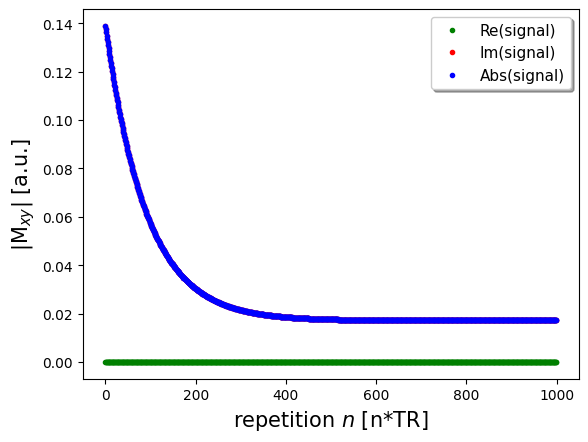

In [34]:
plot('simu', 'repetition $n$ [n*TR]', '|M$_{xy}$| [a.u.]')

We can also check the dimensions of the created signal files by displaying the header files.

In [35]:
! cat simu.hdr

# Dimensions
1 1 1 1 1 1000 1 1 1 1 1 1 1 1 1 1 
# Command
sim --ODE --seq FLASH,TR=0.0041,TE=0.0025,Nrep=1000,ipl=0,ppl=0,Trf=0.001,FA=8,BWTP=4 -1 3:3:1 -2 1:1:1 simu 
# Files
 >simu
# Creator
BART v0.9.00-633-geee06d5


The time dimension is located in BARTs echo-time dimension (the fifth dimension).

Feel free to play with the parameters in the call above. The next cell includes an additional example for an inversion-recovery bSSFP sequence.

0.078152


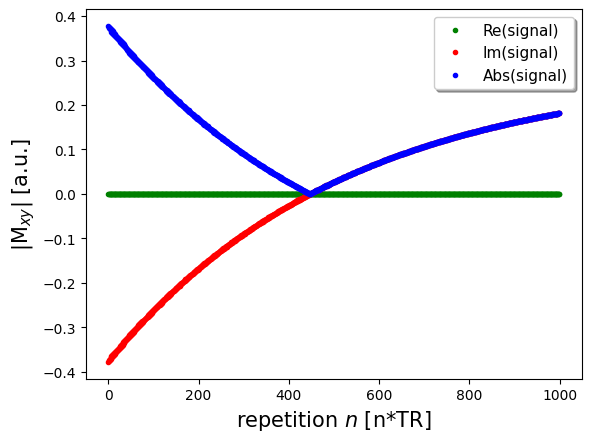

In [36]:
# FLASH simulation
! bart sim --ODE --seq IR-BSSFP,TR=0.0045,TE=0.00225,Nrep=1000,ipl=0,pinv,ppl=0.0225,Trf=0.001,FA=45,BWTP=4 -1 3:3:1 -2 1:1:1 simu

plot('simu', 'repetition $n$ [n*TR]', '|M$_{xy}$| [a.u.]')

Relaxation parameters are passed to the `sim` tool following the convention:

> $T_1$ and $T_2$ follow with `-1 min:max:#values` and `-2 min:max:#values`

### Comparison to Analytical IR bSSFP Model

Next, the simulation tool is validated for an inversion prepared bSSFP sequence.

Therefore, a single voxel is simulated with `sim` and compared to the result of the analytical `signal` tool output. The theoretical model follows [Schmitt, P. et al. 2004]:

$$S(n\textrm{TR})=S_{stst} - (S_{stst} + S_0)e^{-\frac{n\textrm{TR}}{T_1^*}}.$$

The relaxation parameter follow with
$$
   \begin{align}
		T_1 &= T_1^*\frac{S_0}{S_{stst}}\cos\left(\frac{\alpha}{2}\right),\\
		T_2 &= T_1^*\sin^2\left(\frac{\alpha}{2}\right)\left[1-\frac{S_{stst}}{S_0}\cos\left(\frac{\alpha}{2}\right)\right],~~~\textrm{and}\\
		M_0 &= \frac{S_0}{\sin\left(\frac{\alpha}{2}\right)}.
	\end{align}
$$

0.107357
1.414031
ODE-Analytical Comparison


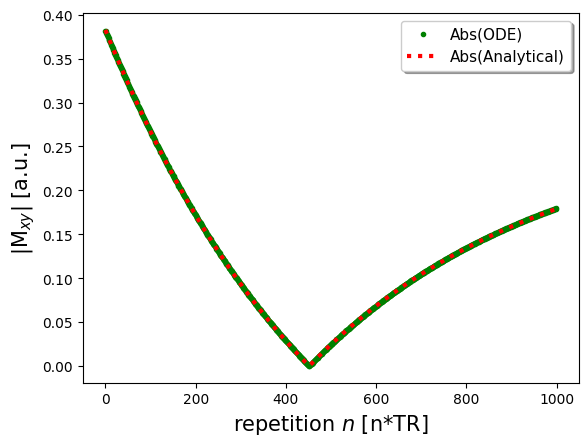

In [37]:
# ODE Simulation with very short pulses (-> close to hard pulses)
! bart sim --ODE --seq IR-BSSFP,TR=0.0045,TE=0.00225,Nrep=1000,ipl=0,pinv,ppl=0.0002,Trf=0.0001,FA=45,BWTP=4 -1 3:3:1 -2 1:1:1 ode


# Analytical Model
! bart signal -I -B -r0.0045 -e0.00225 -f45 -n1000 -1 3:3:1 -2 1:1:1 signal

# Comparison
! bart nrmse signal ode

print("ODE-Analytical Comparison")
plot2('ode', 'signal')

### Off-Resonance

An other supported feature are off-resonance values passed in rad/s. Here, an example for the off-resonance profile of a bSSFP sequence is shown.

In [38]:
%%bash

T1=1.6
T2=0.09
REP=1000
TE=0.00225

Nspins=100

for i in `seq 0 $((Nspins-1))`;
do
    OFF=$(echo $i $Nspins $TE | awk '{printf "%3.6f\n",2*3.1415*1/$3*$1/$2}') # [rad/s]

    bart sim --ODE --seq BSSFP,TR=0.0045,TE=$TE,Nrep=$REP,ipl=0,pinv,ppl=$TE,Trf=0.001,FA=45,BWTP=4,off=$OFF -1 $T1:$T1:1 -2 $T2:$T2:1 sig_$(printf "%03.0f" $i) &>/dev/null

    bart slice 5 $((REP-1)) sig_$(printf "%03.0f" $i) sig2_$(printf "%03.0f" $i)
done

rm sig_*.{cfl,hdr}

bart join 6 $(ls sig2_*.cfl | sed -e 's/\.cfl//') data

rm sig2_*.{cfl,hdr}

Off-Resonance Plot


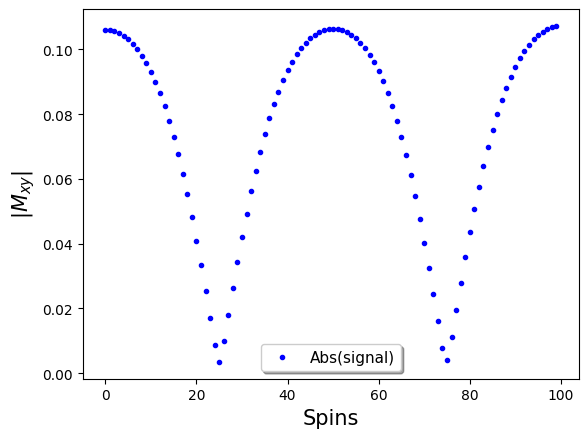

In [40]:
print("Off-Resonance Plot")
plot('data', 'Spins', '$|M_{xy}|$', True)

### Slice-Profile

The simulation tool also supports slice-selection z-gradients passed using the `mom-sl` flag.
It gives the option to simulate full slice-profiles.

In [41]:
%%bash

T1=0.832
T2=0.08
REP=1
TRF=0.001
TE=0.0015
TR=0.003
FA=30
NSPINS=100

G_SS=0.012 # [T/m]
DISTANCE=0.010 # [m]

for i in `seq 0 $((NSPINS-1))`;
do
    Z=$(echo $DISTANCE $i $NSPINS | awk '{printf "%f\n",$1/$3*($2-$3/2)}') # [rad/s]

    TSIM=$(bart sim --ODE --seq FLASH,TR=$TR,TE=$TE,Nrep=$REP,ipl=0,ppl=0,Trf=$TRF,FA=$FA,BWTP=1,slice-thickness=${Z},sl-grad=${G_SS},Nspins=1 -1 $T1:$T1:1 -2 $T2:$T2:1 sig_$(printf "%03.0f" $i))

    bart slice 5 $((REP-1)) sig_$(printf "%03.0f" $i) sig2_$(printf "%03.0f" $i)
done

rm sig_*.{cfl,hdr}

bart join 6 $(ls sig2_*.cfl | sed -e 's/\.cfl//') data2

rm sig2_*.{cfl,hdr}

Slice-Profile Plot


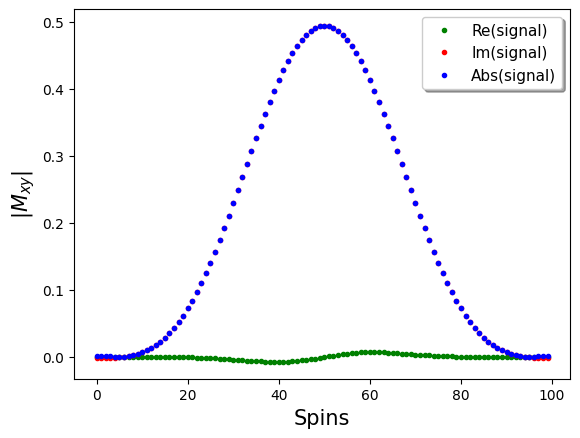

In [42]:
print("Slice-Profile Plot")
plot('data2', 'Spins', '$|M_{xy}|$')

### State-Transition Matrices

All simulations presented here are performed with the default ODE solver simulation.
If you want to run **state-transition matrix** based simulations just exchange the `--ODE` flag with the `--STM` flag.

It exploits the repeating patterns in sequences efficiently and reduced the computational costs markedly.

In [43]:
%%bash

# FLASH simulation

# Measure time of ODE simulation

start_time=$(date +%s.%3N)

bart sim --ODE --seq FLASH,TR=0.0041,TE=0.0025,Nrep=3000,ipl=0,ppl=0,Trf=0.001,FA=8,BWTP=4 -1 3:3:1 -2 1:1:1 simu

end_time=$(date +%s.%3N)

TODE=$(echo "$end_time-$start_time" | bc)



# Measure time of STM simulation
start_time2=$(date +%s.%3N)

bart sim --STM --seq FLASH,TR=0.0041,TE=0.0025,Nrep=3000,ipl=0,ppl=0,Trf=0.001,FA=8,BWTP=4 -1 3:3:1 -2 1:1:1 simu

end_time2=$(date +%s.%3N)

TSTM=$(echo "$end_time2-$start_time2" | bc)

# Print Result
echo -e "Elapsed time\nODE: ${TODE} s\tSTM: ${TSTM} s"

0.152989
0.006464
Elapsed time
ODE: .238 s	STM: .087 s


## Digital Objects with BART

This section of the tutorial introduces the work

> Nick Scholand, Martin Schilling, Martin Heide, Martin Uecker.  
> Digital Reference Objects with BART.  
> In Proc. Intl. Soc. Mag. Reson. Med. 31; 3118 (2023).

on digital objects in BART.

Please check out the [tutorial](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2023) for a more detailed introduction.

### Functionallity

Digital objects in BART are created with the `phantom` tool.
It can be used from the command line. Some basic help is provided when passing the `-h` flag.

In [44]:
%%bash

# Overview about the functionality of the sim tool.
bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [--NIST] [--SONAR] [--BRAIN] [--ELLIPSOID] [--ellipsoid_center d:d:d] [--ellipsoid_axes f:f:f] [-N d] [-B] [--FILE <file>] [-x d] [-g d] [-3] [-b] [-r d] [--rotation-angle f] [--rotation-steps d] [--coil ...] <output> 

Image and k-space domain phantoms.

-s nc                       nc sensitivities
-S nc                       Output nc sensitivities
-k                          k-space
-t file                     trajectory
-G                          geometric object phantom
-T                          tubes phantom
--NIST                      NIST phantom (T2 sphere)
--SONAR                     Diagnostic Sonar phantom
--BRAIN                     BRAIN geometry phantom
--ELLIPSOID                 Ellipsoid.
--ellipsoid_center d:d:d    x,y,z center coordinates of ellipsoid.
--ellipsoid_axes f:f:f      Axes lengths of ellipsoid.
-N num                      Random tubes phantom with num tubes
-B                          BART logo
-

Various geometries are already implemented and many functionallity is provided that can not be covered by this tutorial.

One of the basic features of the `phantom` tool is the option to change the sampling rate: `-x <sampling-rate>`.

To compare its influence the next cell creates two geometries with 128 base resolution (which is the default) and with 512.

In [45]:
%%bash

# Simulate phantom with default sampling rate 128
bart phantom p

# Change the sampling rate and simulate a new phantom
NEW_BASE_RESOLUTION=512
bart phantom -x $NEW_BASE_RESOLUTION p2

With a small script both phantoms can be visualized.

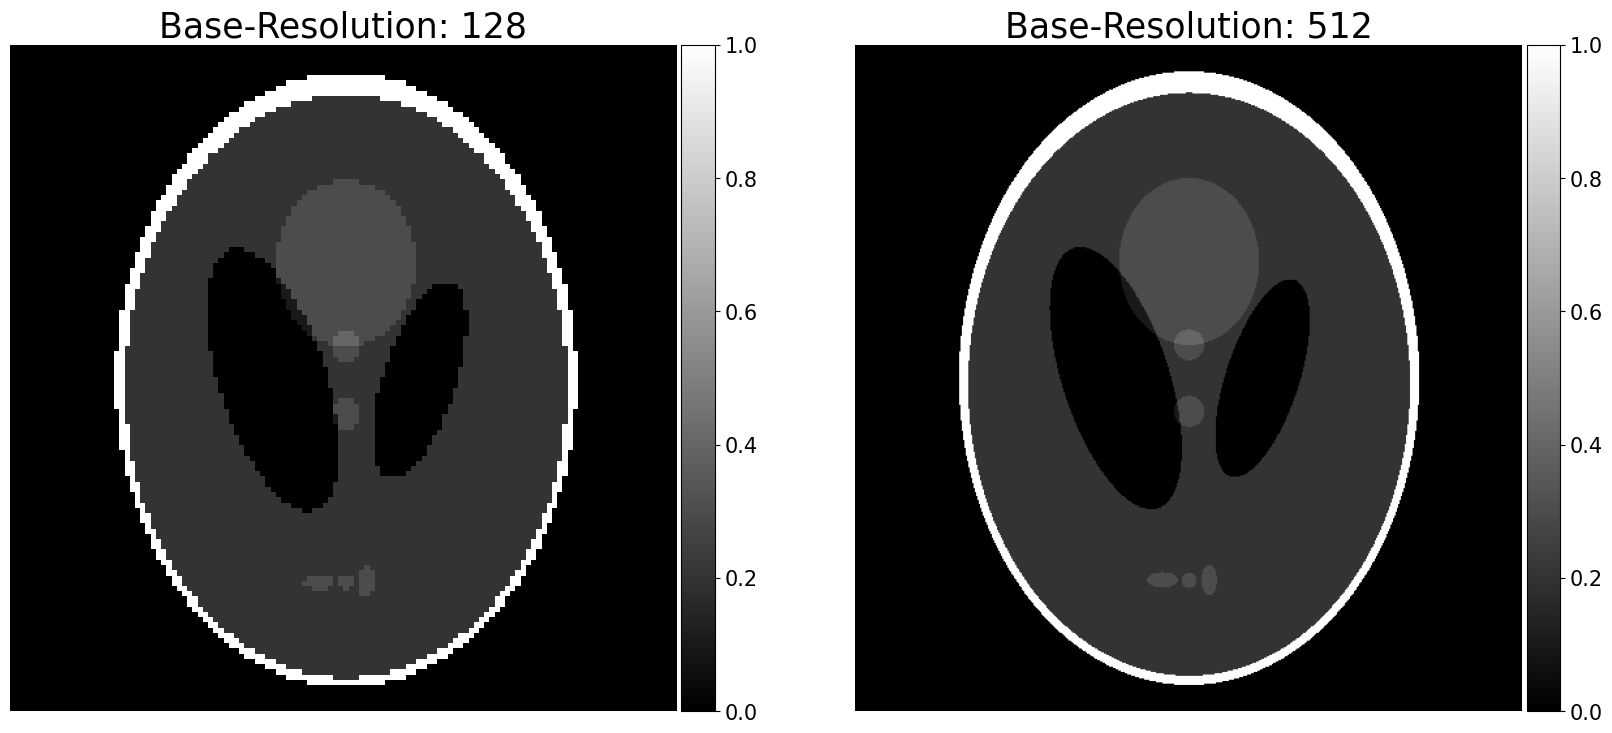

In [46]:
# Rotate phantoms for visualization
!bart transpose 0 1 p pt
!bart transpose 0 1 p2 p2t

# Visualize the two phantoms that were simulated with different base resolutions
imshow2(["pt", "p2t"], ["Base-Resolution: 128", "Base-Resolution: 512"])

The lower resolution simulation shows rectangular edges resulting from a simulation in the spatial domain.

By exploiting the analytical Fourier transform of ellipses, the simulation can be performed natively in the frequency domain and sampled on arbitrary trajectories.

Arbitrary trajectories are passed by `-t <traj-file>`, but first we assume the default fully-sampled Cartesian sampling.

A simulation in frequency space is performed by adding the flag `-k` to the `phantom` command.

In [47]:
%%bash

# Simulation of a phantom in SPATIAL domain
bart phantom spa

# Simulation in FREQUENCY domain
bart phantom -k ksp

# For better visualization the frequency data is inverse Fourier transformed
bart fft -i 7 ksp reco

Both is visualized next to each other.

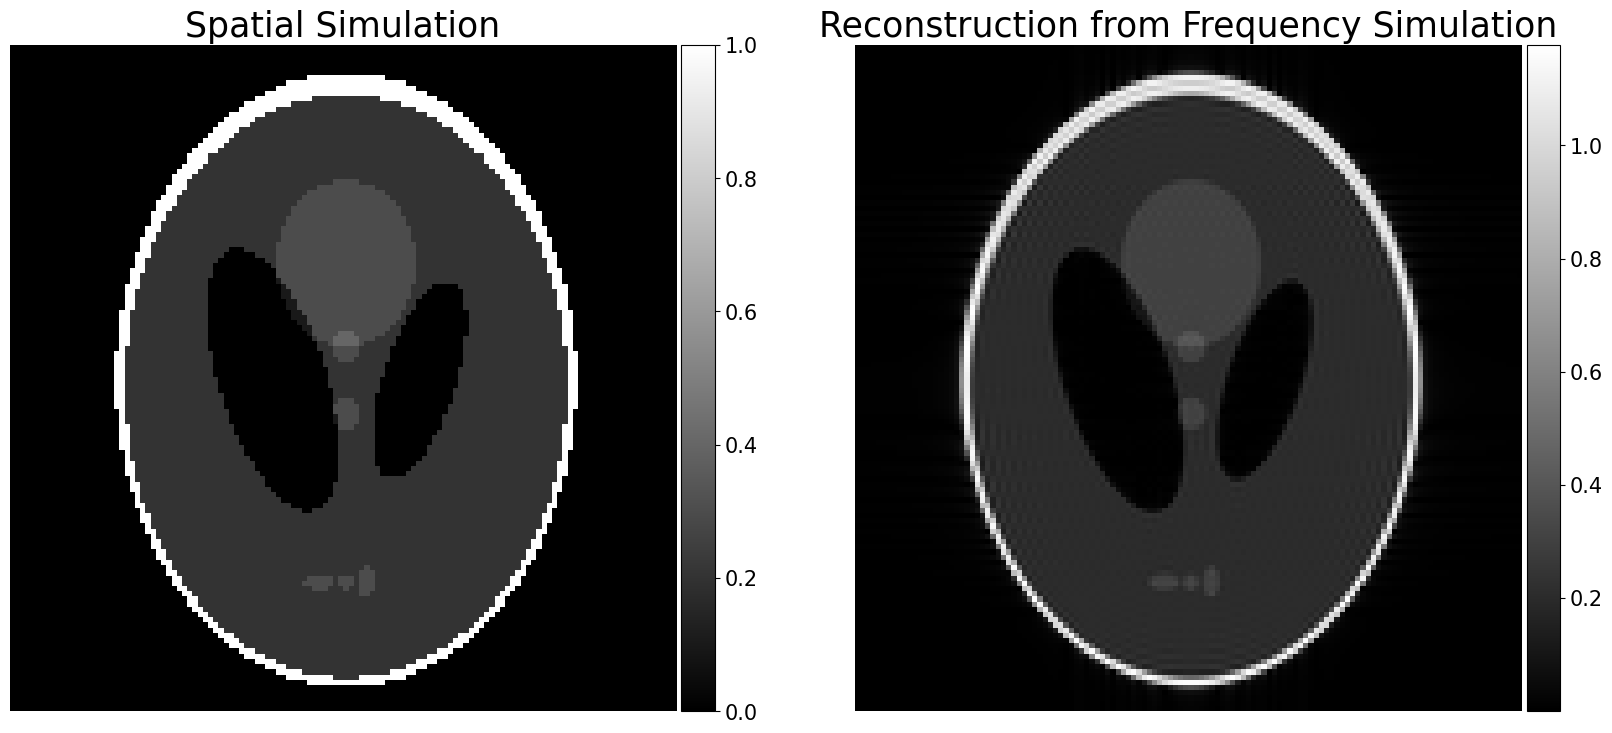

In [48]:
# Rotate for visualization
!bart transpose 0 1 spa spat
!bart transpose 0 1 reco recot

imshow2(["spat", "recot"], ["Spatial Simulation", "Reconstruction from Frequency Simulation"])

Here, both simulation are performed with the default base-resolution.

The reconstructed image from the frequency simulation shows the characteristic **Gibbs ringing artifacts**.

#### 2D Geometries

The highlighted 2D geometries cover the T2 sphere of the **NIST phantom** (model 130), the **BART logo**, and a 4 component **realistic brain** geometry.
The individual geometries are specified with the flags `--NIST`, `-B`, and `--BRAIN`, respectively.

In general, arbitrary objects can be simulated. See the [tutorial](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2023) on how to design your own geometry with inkscape and import it **with native Fourier representation**(!) into BART's `phantom` tool.

In [49]:
%%bash

# Creation of NIST phantom in spatial domain
bart phantom --NIST -x256 nist_sp

# Creation of BART phantom in spatial domain
bart phantom -B bart_sp

# Creation of BRAIN phantom in spatial domain
bart phantom --BRAIN brain_sp

# Creation of NIST phantom in Fourier domain with reconstruction
bart phantom --NIST -x256 -k ksp
bart fft -i 7 ksp nist_reco

# Creation of BART phantom in Fourier domain with reconstruction
bart phantom -B -k ksp
bart fft -i 7 ksp bart_reco

# Creation of BRAIN phantom in Fourier domain with reconstruction
bart phantom --BRAIN -k ksp
bart fft -i 7 ksp brain_reco

Again the simulations can be performed in spatial and frequency domain.

##### Spatial Simulation

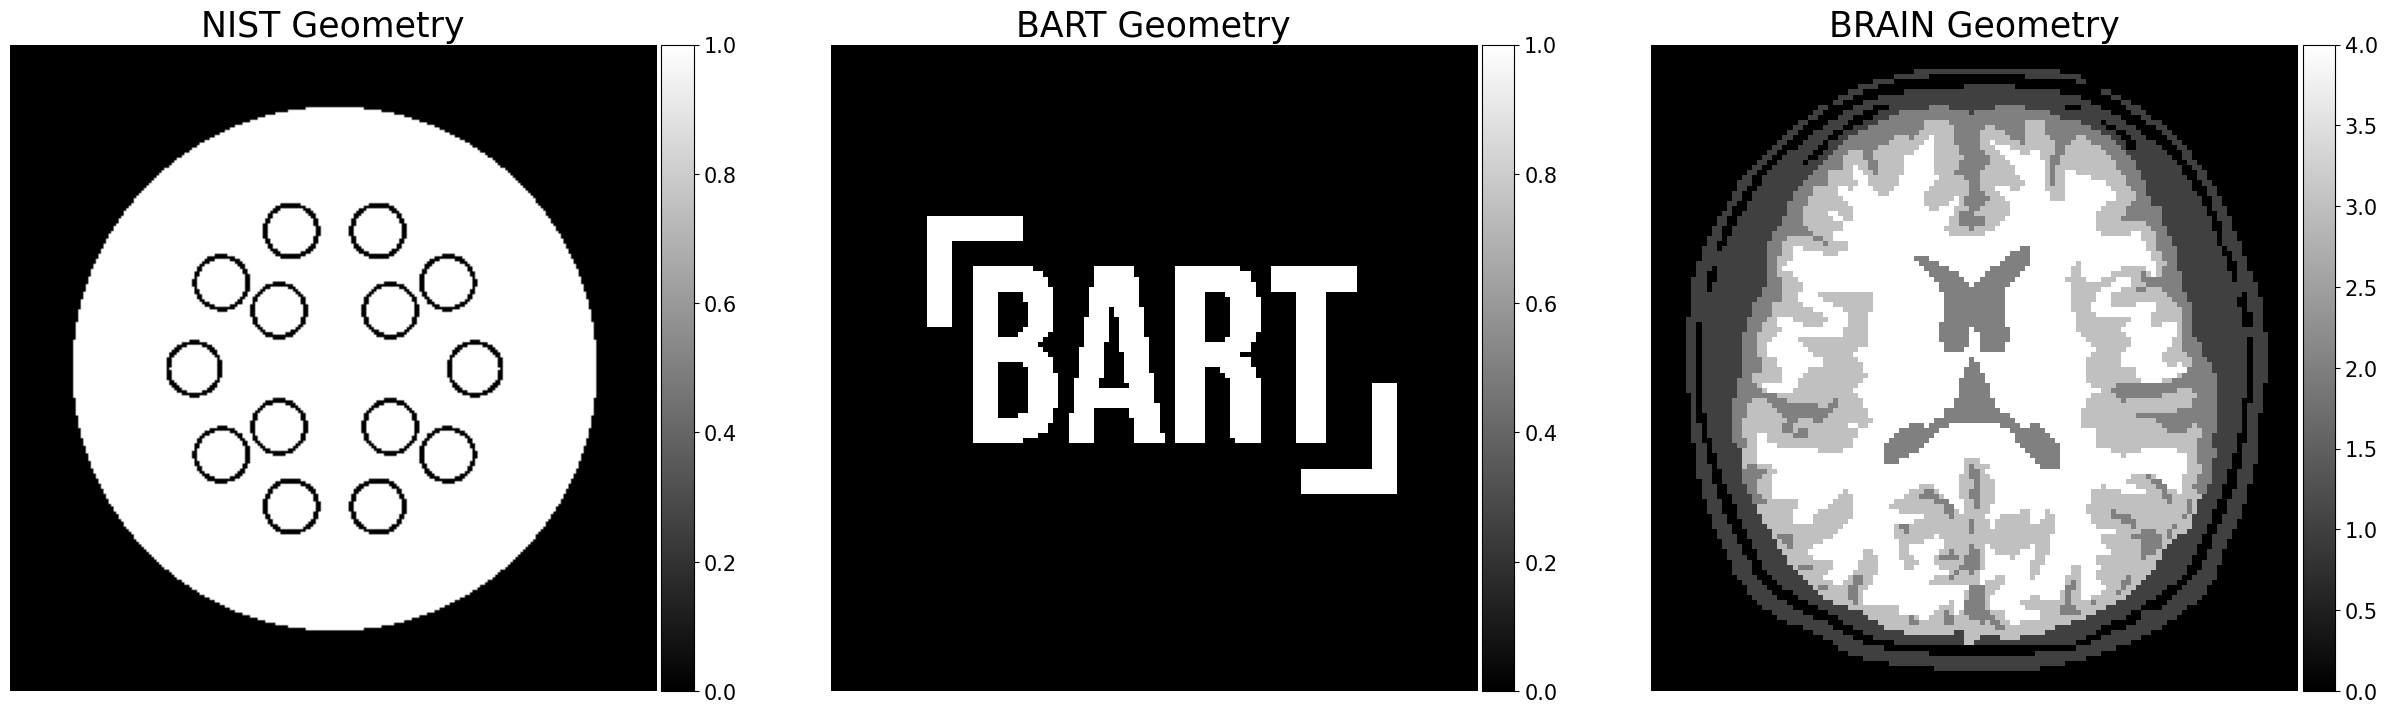

In [50]:
imshow2(["nist_sp", "bart_sp", "brain_sp"], ["NIST Geometry", "BART Geometry", "BRAIN Geometry"])

##### Reconstruction from Frequency Simulation

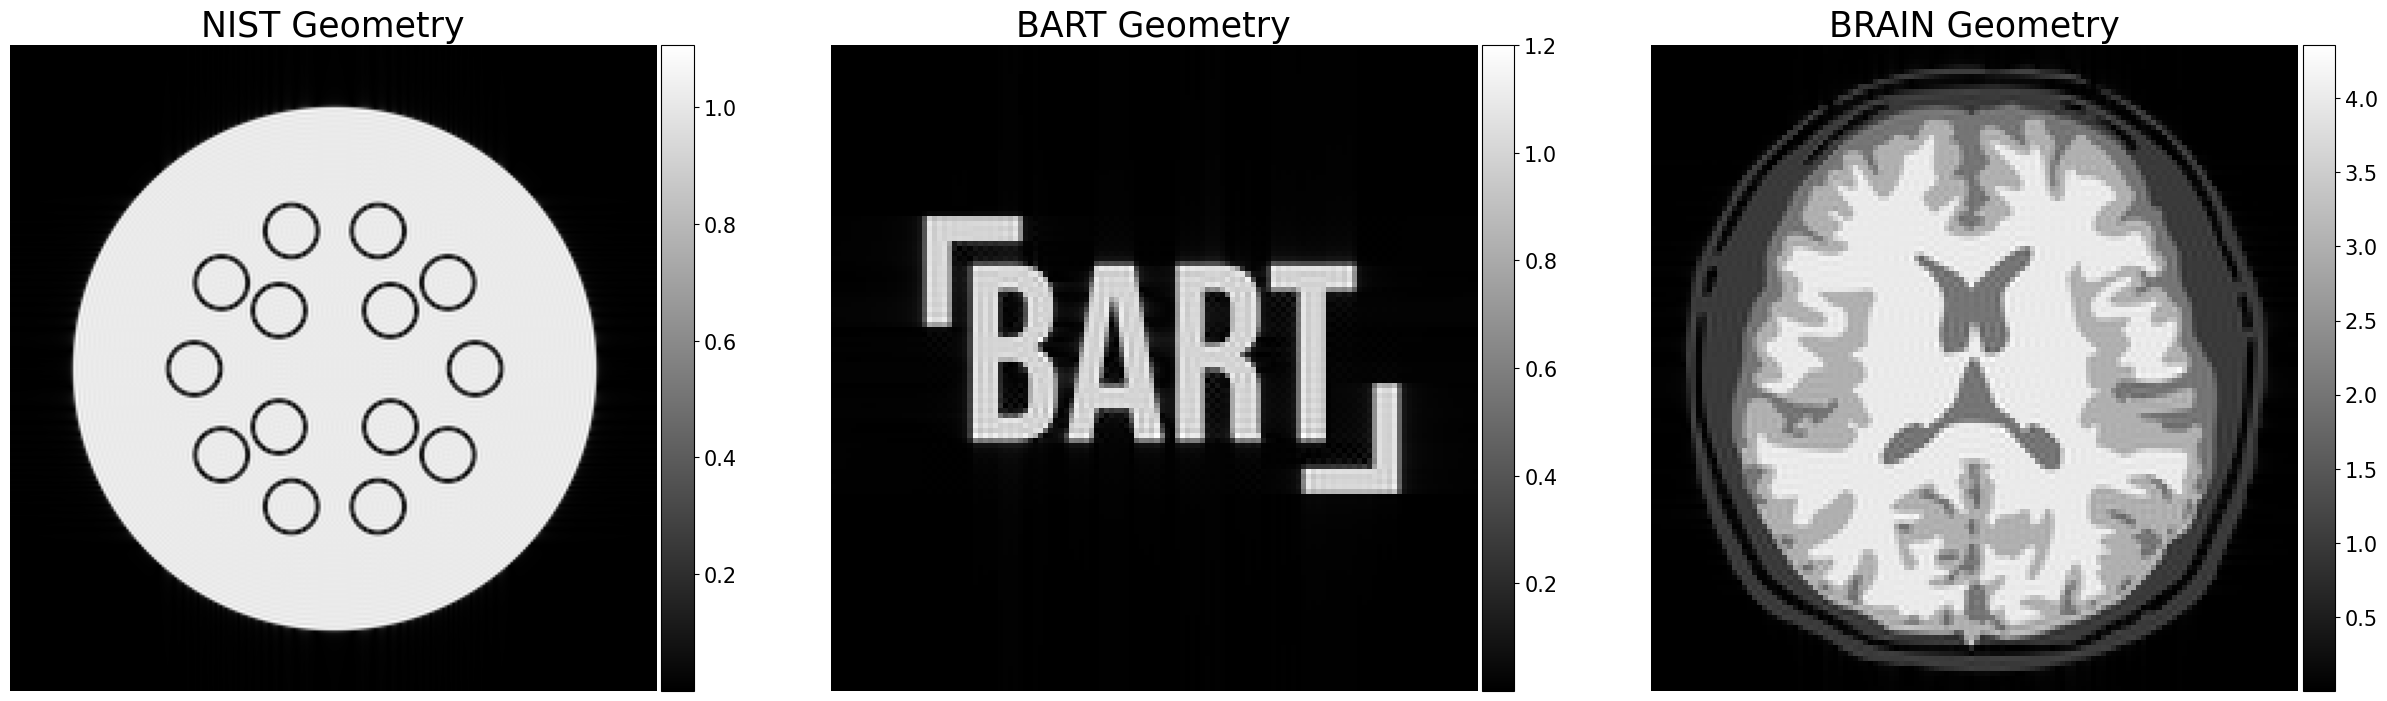

In [51]:
imshow2(["nist_reco", "bart_reco", "brain_reco"], ["NIST Geometry", "BART Geometry", "BRAIN Geometry"])

### Realistic Coil Sensitivity Simulations

After presenting some already implemented geometries and introducing a workflow to simulate custom geometries with BART's `phantom` tool
in the next step the simulation of realistic coil sensitivity profiles is shown.


#### Theory

Let us give some theoretical background on how to simulate realistic coil signals for the case of 2D or 3D signals with $k=1,...,64$ receiver coil channels.
The sensitivity profiles $s_k$ of the $k$-th coil are smooth functions, therefore one can represent them by few Fourier coefficients e.g. over the following set of frequencies

$$
\text{supp}\{\mathcal{F}(s_k)\} = \{-2,-1,0,1,2\}^3 =: \mathcal{S}.
$$

The set of Fourier coefficients $\{\mathcal{F}(s_k)(\delta)\}_{k=1,...,64,\delta\in\mathcal{S}}$ is available in BART.
Simulating a realistic signal of the $k$th coil in the spatial domain reduces to the evaluation of the product

$$
\rho(r) \cdot s_k(r)
$$

on e.g. a Cartesian grid $r\in\mathcal{Z}^3$.
The simulations can also be performed in the Fourier domain

$$
\mathcal{F}(\rho\cdot s_k)(\omega) = \mathcal{F}(\rho) * \mathcal{F}(s_k) = \sum_{\delta\in\mathcal{S}} \mathcal{F}(\rho)(\omega - \delta) \cdot \mathcal{F}(s_k)(\delta),
$$

where in the first equation the Fourier convolution theorem is applied and one obtains the last equation by using the definition of the convolution and realizing that $\mathcal{F}(s_k)(\delta) = 0$ if $\delta\not\in\mathcal{S}$ by construction.

Therefore, the expression $\mathcal{F}(\rho\cdot s_k)(\omega)$ can be cheaply computed on any trajectory $\{\omega_1,...\}\subset \mathcal{R}^d$ for each coil $k=1,...,64$ in any dimension 2D or 3D.


The `phantom` tool provides a simple interface to simulate these 2D and 3D sensitivities. While both can be used for all geometries, it is not recommended using the 2D sensitivities for 3D geometries.


#### Basics

Currently, two types of coils can be simulated with BART.
They can be chosen individually with the `phantom` tools `--coil` interface.

In [54]:
%%bash

bart phantom --coil h

Usage of sub-option: --coil [HEAD_2D_8CH],[HEAD_3D_64CH]

Sub-options: configure type of coil

HEAD_2D_8CH     2D head coil with up to 8 channels
HEAD_3D_64CH    3D head coil with up to 64 channels
h               help


Both datasets are extracted from phantom measurements using head coils.
If you do not specify any of them a 2 dimensional set with up to 8 channels (`HEAD_2D_8CH`) is the default for 2D geometries and a 3D set with up to 64 channels for 3D geometries (`HEAD_3D_64CH`).


#### Realistic Coil Sensitivities with 2D Geometries

The number of simulated coils is specified in BART's `phantom` tool with `-s <number>`. By choosing `-S <number>` only the coils are simulated without the geometry.

For the 2D sensitivities up to 8 channels can be chosen.

In the following cell, eight profiles are simulated (`-s8`) but only three are visualized.

In [55]:
%%bash

# Estimation of sensitivity profiles
bart phantom -S8 sens

# Extraction of individual profiles for visualization
bart slice 3 0 sens sens0
bart slice 3 4 sens sens1
bart slice 3 7 sens sens2

# Simulation of BRAIN phantom with sensitivity profiles in spatial domain
bart phantom --BRAIN -s8 sp

# Extraction of individual coil images for visualization
bart slice 3 0 sp sp0
bart slice 3 4 sp sp1
bart slice 3 7 sp sp2

The individual profiles are:

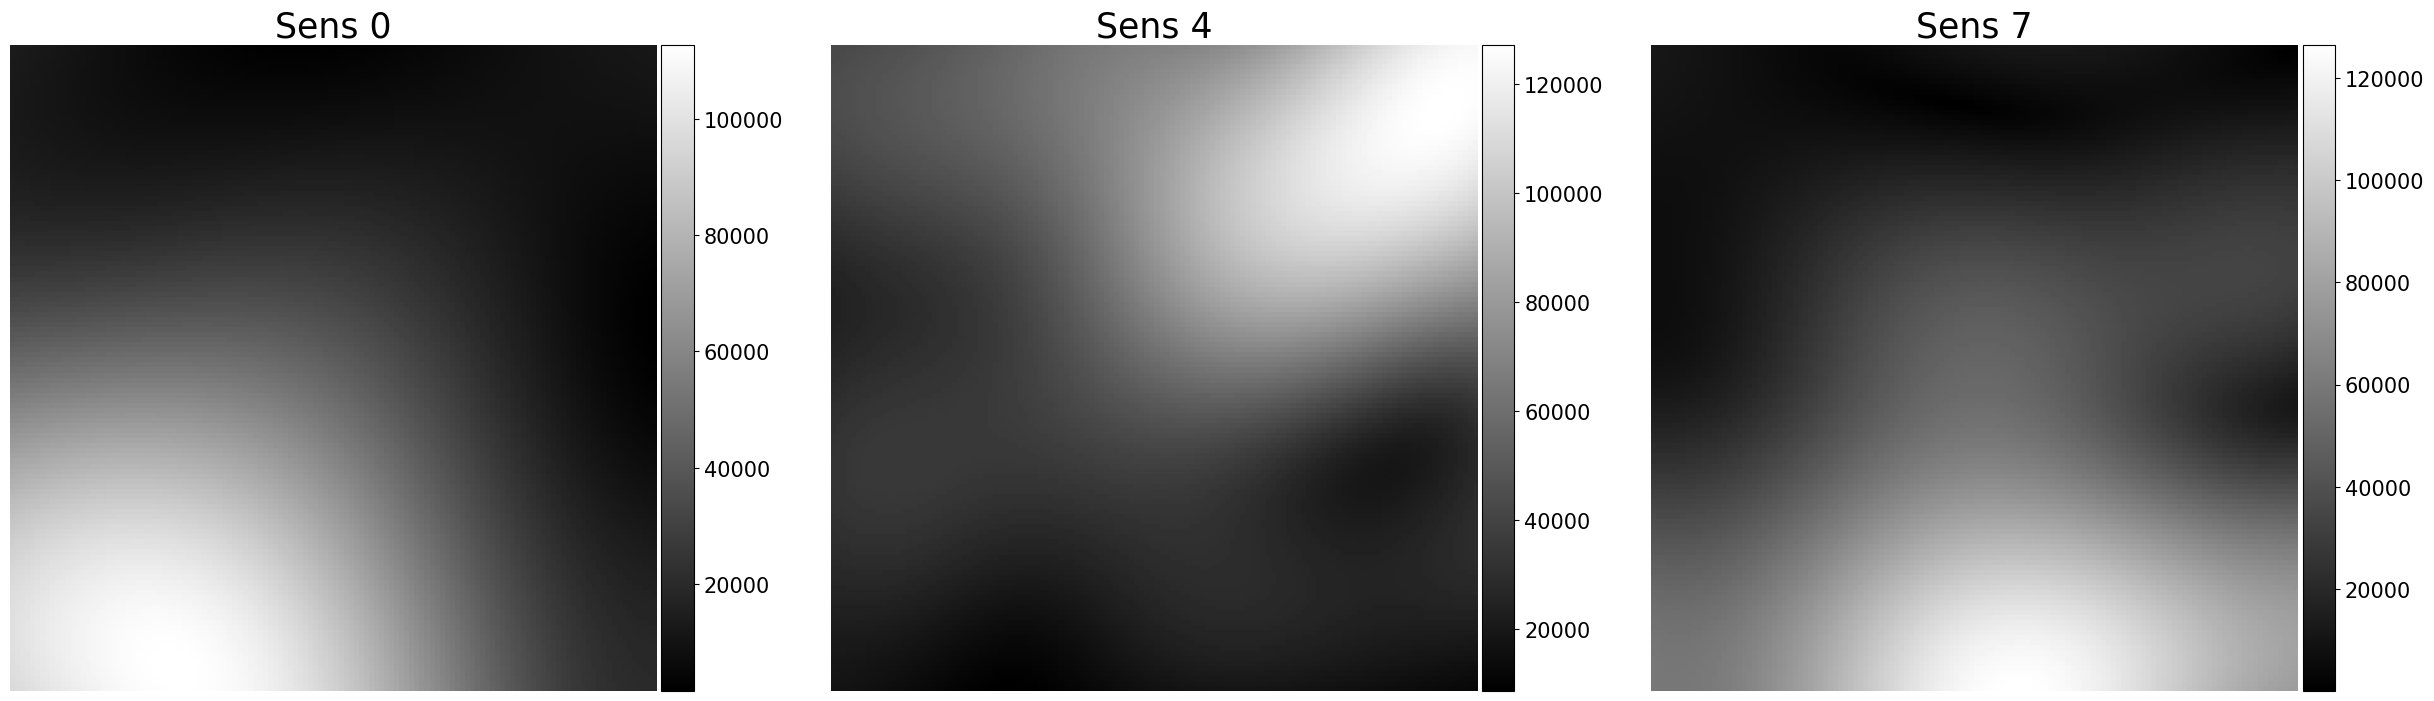

In [56]:
imshow2(["sens0", "sens1", "sens2"], ["Sens 0", "Sens 4", "Sens 7"])

while the simulated objects in spatial domain are:

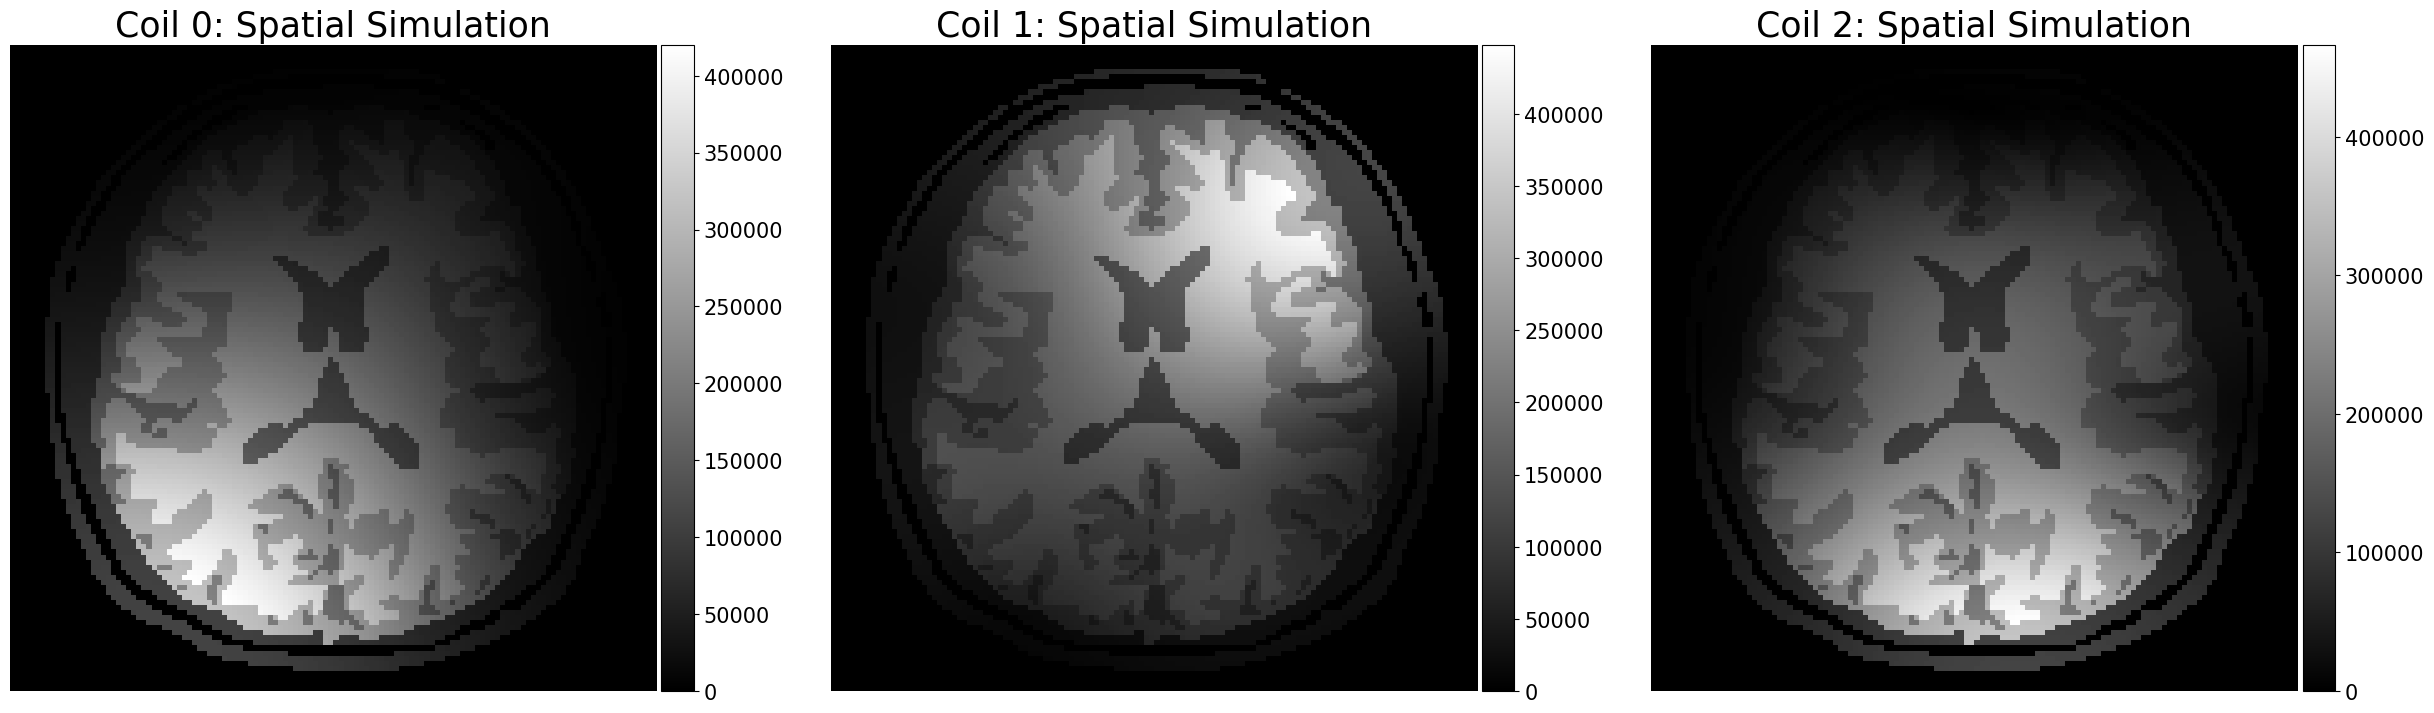

In [57]:
imshow2(["sp0", "sp1", "sp2"], ["Coil 0: Spatial Simulation", "Coil 1: Spatial Simulation", "Coil 2: Spatial Simulation"])

The simulation of coil profiles can also be performed in frequency domain, but is too computationally expensive to run it on Google Colab. We encourage you to run it locally on your own server using multiple threads.

In [58]:
%%bash

# Simulation of BRAIN phantom with sensitivity profiles in frequency domain
## Look out! This is computationally expensive and not recommended to run online
## Run times on local machines were in the order of multiple minutes

# bart phantom --BRAIN -s3 -k ksp
# bart fft -i 7 ksp reco

# bart slice 3 0 reco reco0
# bart slice 3 1 reco reco1
# bart slice 3 2 reco reco2

In [59]:
# imshow2(["sp0", "sp1", "sp2"],["Coil 0: Reconstruction from Freq. Sim.", "Coil 1: Reconstruction from Freq. Sim.", "Coil 2: Reconstruction from Freq. Sim."])

## Synthetic MRI Simulations

Besides the options to simulate in frequency domain and realistic coil sensitivity profiles, the `phantom` tool can split different geometries in their geometrical components.

This works for the internal **BRAIN**, **TUBES**, **SONAR**, and **BART** geometry but is also supports by the arbitrary design import with `--FILE <geomfile>`.

The split into the components is performed by adding the `-b` flag.

In [62]:
%%bash

# Simulation of BRAIN geometry in spatial domain with component splitting
bart phantom --BRAIN -b spa

# Extraction of individual profiles for visualization
bart slice 6 0 spa spa0
bart slice 6 1 spa spa1
bart slice 6 2 spa spa2
bart slice 6 3 spa spa3

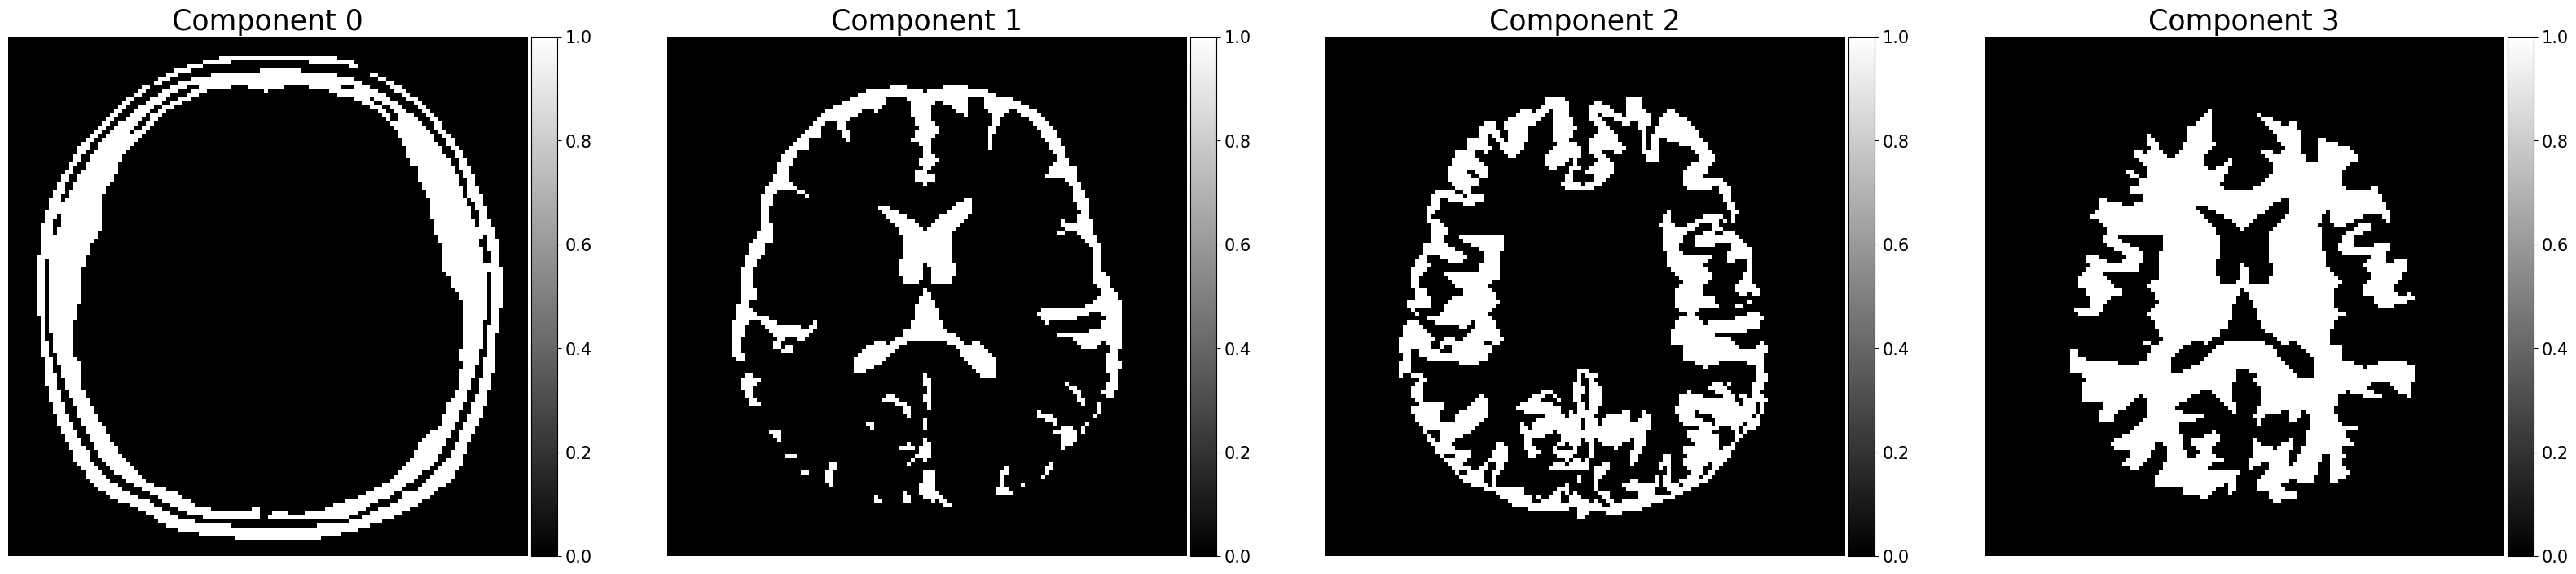

In [63]:
imshow2(["spa0", "spa1", "spa2", "spa3"], ["Component 0", "Component 1", "Component 2", "Component 3"])

The splitting can be combined with the simulation of coils and can be performed in frequency domain.
For complex geometries such as the BRAIN geometry it is computationally expensive and not recommended in this tutorial.

In [64]:
%%bash

# Simulation of BRAIN geometry in frequency domain with component splitting
## Look out! This is computationally expensive and not recommended to run online
## Run times on local machines were in the order of multiple minutes

# bart phantom --BRAIN -b -k -s2 ksp
# bart slice 3 0 ksp ksp2

# # Reconstruction for visualization
# bart fft -i 7 ksp2 reco

# # Extraction of individual profiles for visualization
# bart slice 6 0 reco reco0
# bart slice 6 1 reco reco1
# bart slice 6 2 reco reco2
# bart slice 6 3 reco reco3

In [65]:
# imshow2(["reco0", "reco1", "reco2", "reco3"], ["Component 0", "Component 1", "Component 2", "Component 3"])

The simulation including a realistic coil profile, a frequency domain simulation and a component split is demonstrated for the less complex NIST phantom geometry because of its reduces computational costs.

In [66]:
%%bash

# Simulation of BRAIN geometry in spatial domain with component splitting
bart phantom --NIST -b -k -s2 ksp
bart slice 3 0 ksp ksp2

# Reconstruction for visualization
bart fft -i 7 ksp2 reco

# Extraction of individual profiles for visualization
bart slice 6 0 reco reco0
bart slice 6 1 reco reco1
bart slice 6 2 reco reco2
bart slice 6 3 reco reco3

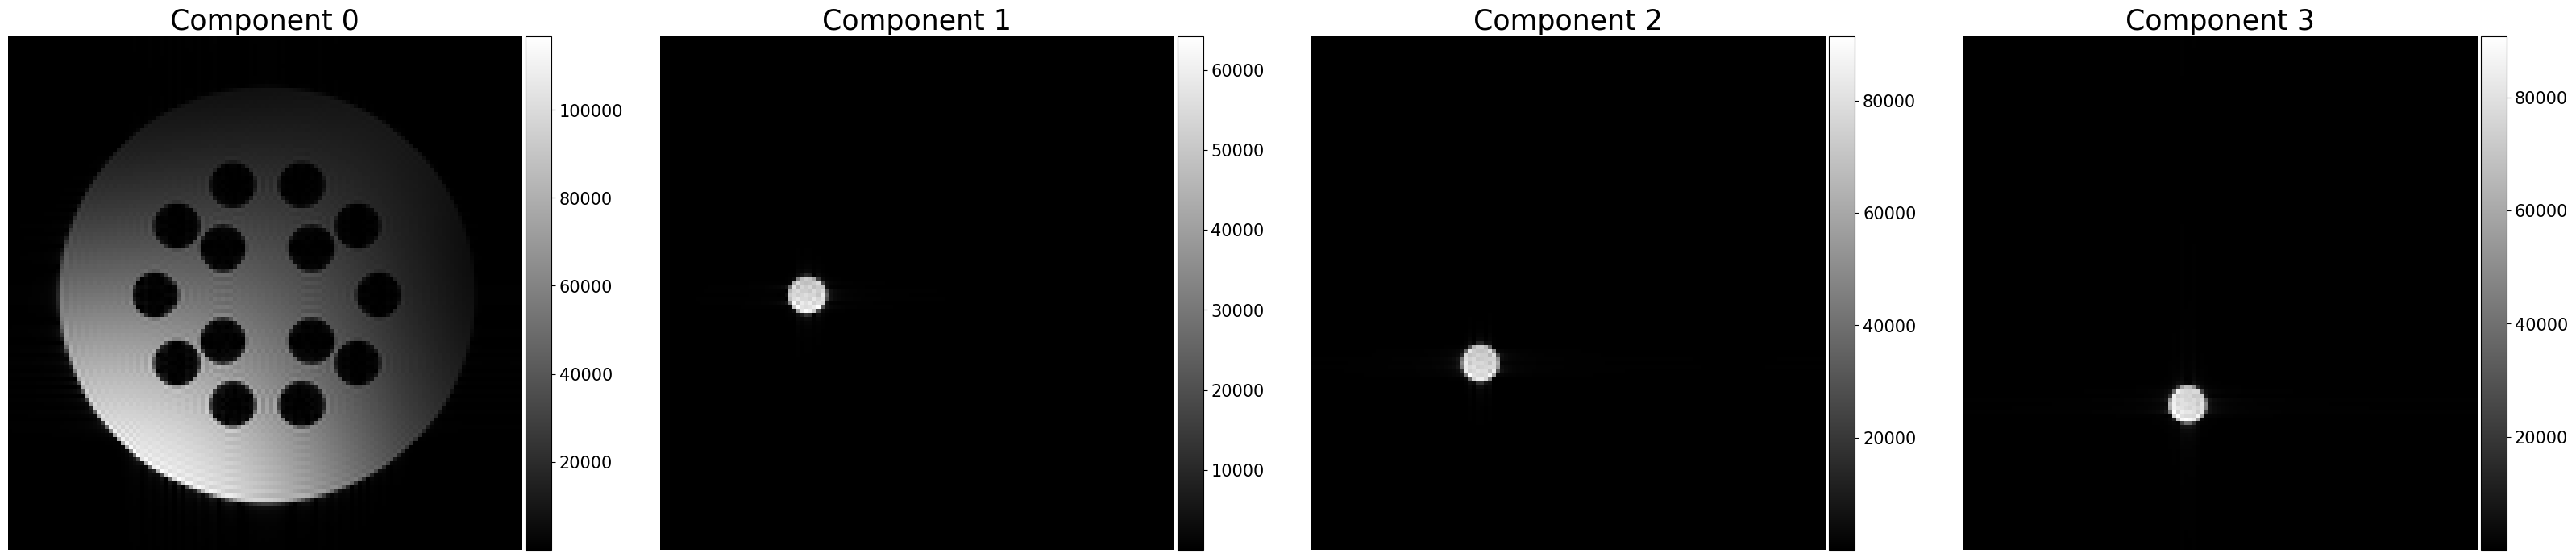

In [67]:
imshow2(["reco0", "reco1", "reco2", "reco3"], ["Component 0", "Component 1", "Component 2", "Component 3"])

All in all, the feature of splitting the geometries into their individual components can be used to create realistic synthetic MRI datasets with BART.

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2023/digital-objects/figures/component_time.png?raw=1" width=1600>

For each individual component a signal is simulated with a Bloch simulation.
This tutorial makes use of BART's internal Bloch simulator.
A detailed introduction and interactive tutorial can be found on [Github](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2022).

The simulated signals are point-wise multiplied with the corresponding geometric component.
Afterwards, the sum over all geometric components is calculated.
Due to the linearity of the Fourier transform this operatrion can be performed in spatial and frequency domain creating a versatile tool for simulating
synthetic MRI data with realistic signal evolution, frequency domain artifacts, coil simulations, and geometries.

Additionally, the frequency space data can be sampled on arbitrary trajectories.
In the following example a radial trajectory is created with BART's `traj` tool using the `-r` flag.
By passing the trajectory file to the `phantom` tool using `-t <traj-file>` the simulated data is sampled on the provided trajectory.

In [68]:
%%bash

## Relaxation parameters for Brain phantom
T1=(0.6 3 1.5 0.8)
T2=(0.08 1 0.06 0.1)

# Simulation Parameters
#       Run `bart sim --seq h` for more details
SEQ=IR-FLASH    # Sequence Type
TR=0.0034       # Repetition Time [s]
TE=0.0021       # Echo Time [s]
REP=600         # Number of repetitions
IPL=0.01        # Inversion Pulse Length [s]
ISP=0.005       # Inversion Spoiler Gradient Length [s]
PPL=0           # Preparation Pulse Length [s]
TRF=0.001       # Pulse Duration [s]
FA=6            # Flip Angle [degree]
BWTP=4          # Bandwidth-Time-Product
OFF=0           # Off-Resonance [rad/s]
SLGRAD=0        # Slice Selection Gradient Strength [T/m]
SLTHICK=0       # Thickness of Simulated Slice [m]
NSPINS=1        # Number of Simulated Spins

# Run Simulations

## 0th component
bart sim --ODE \
	--seq $SEQ,TR=$TR,TE=$TE,Nrep=$REP,ipl=$IPL,isp=$ISP,ppl=$PPL,Trf=$TRF,FA=$FA,BWTP=$BWTP,off=$OFF,sl-grad=$SLGRAD,slice-thickness=$SLTHICK,Nspins=$NSPINS \
	-1 ${T1[0]}:${T1[0]}:1 -2 ${T2[0]}:${T2[0]}:1 \
	_simu00

## 1st component
bart sim --ODE \
	--seq $SEQ,TR=$TR,TE=$TE,Nrep=$REP,ipl=$IPL,isp=$ISP,ppl=$PPL,Trf=$TRF,FA=$FA,BWTP=$BWTP,off=$OFF,sl-grad=$SLGRAD,slice-thickness=$SLTHICK,Nspins=$NSPINS \
	-1 ${T1[1]}:${T1[1]}:1 -2 ${T2[1]}:${T2[1]}:1 \
	_simu01

## 2nd component
bart sim --ODE \
	--seq $SEQ,TR=$TR,TE=$TE,Nrep=$REP,ipl=$IPL,isp=$ISP,ppl=$PPL,Trf=$TRF,FA=$FA,BWTP=$BWTP,off=$OFF,sl-grad=$SLGRAD,slice-thickness=$SLTHICK,Nspins=$NSPINS \
	-1 ${T1[2]}:${T1[2]}:1 -2 ${T2[2]}:${T2[2]}:1 \
	_simu02

## 3rd component
bart sim --ODE \
	--seq $SEQ,TR=$TR,TE=$TE,Nrep=$REP,ipl=$IPL,isp=$ISP,ppl=$PPL,Trf=$TRF,FA=$FA,BWTP=$BWTP,off=$OFF,sl-grad=$SLGRAD,slice-thickness=$SLTHICK,Nspins=$NSPINS \
	-1 ${T1[3]}:${T1[3]}:1 -2 ${T2[3]}:${T2[3]}:1 \
	_simu03


# Join individual simulations
bart join 7 _simu00 _simu01 _simu02 _simu03 simu

# Join simulations in a single dimension (-> 6)
bart reshape $(bart bitmask 6 7) 4 1 simu simu2


# Simulated Spatial Components

DIM=192
GEOM_COMP=4
SAMPLES=96
SPOKES=95

## Create trajectory (RADIAL here `-r`)
bart traj -x $SAMPLES -y $SPOKES -r -o 2 traj

## Create phantom based on trajectory in FREQUENCY DOMAIN
bart phantom --BRAIN -b -k -t traj comp_geom_ksp

## Reconstruct the non-Cartesian k-space samples for better visualization
bart nufft -i -d $DIM:$DIM:1 traj comp_geom_ksp comp_geom_img

# Combine simulated Signal and reconstructed Components
bart fmac -s $(bart bitmask 6) comp_geom_img simu2 phantom_img


## Create phantom in SPATIAL DOMAIN
bart phantom --BRAIN -b -x $DIM comp_geom_sp
# Combine simulated Signal and Spatial Components
bart fmac -s $(bart bitmask 6) comp_geom_sp simu2 phantom_img2

0.054243
0.065790
0.046871
0.040749


##### Reconstruction from Non-Cartesian Frequency Domain Simulation

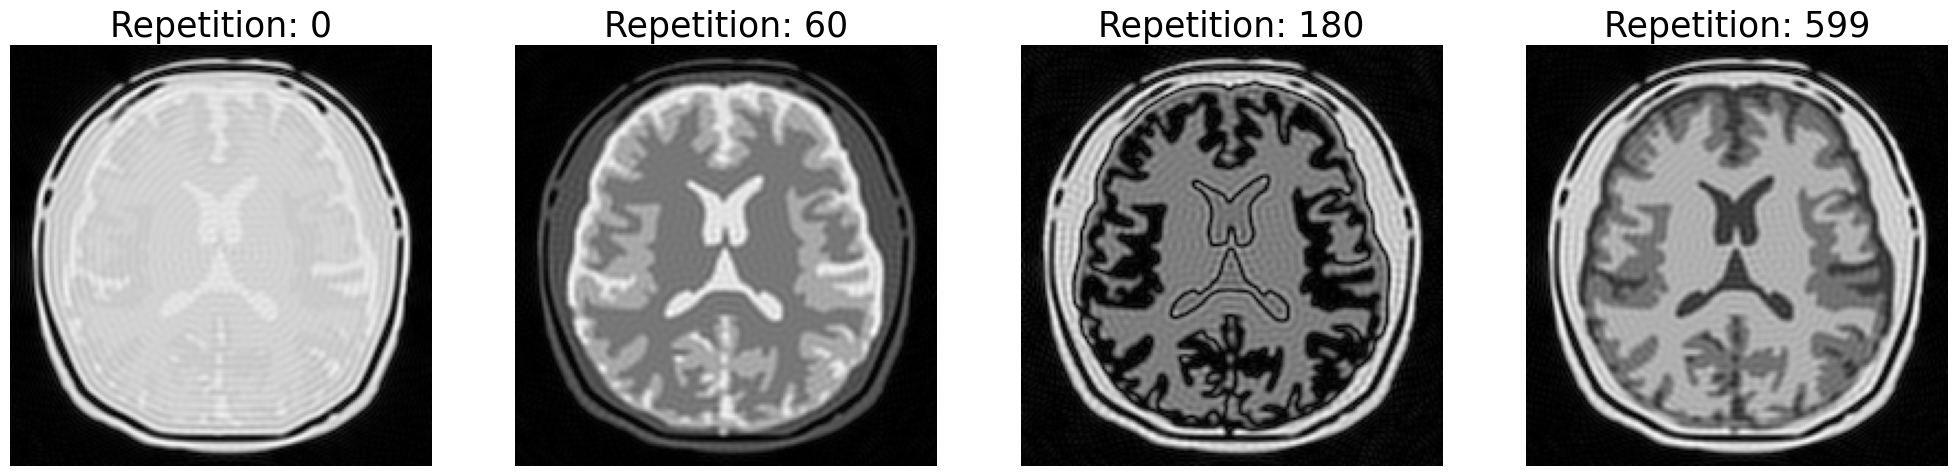

In [69]:
imshow_time('phantom_img', [0, 60, 180, 599])

##### Simulation in Spatial Domain Data

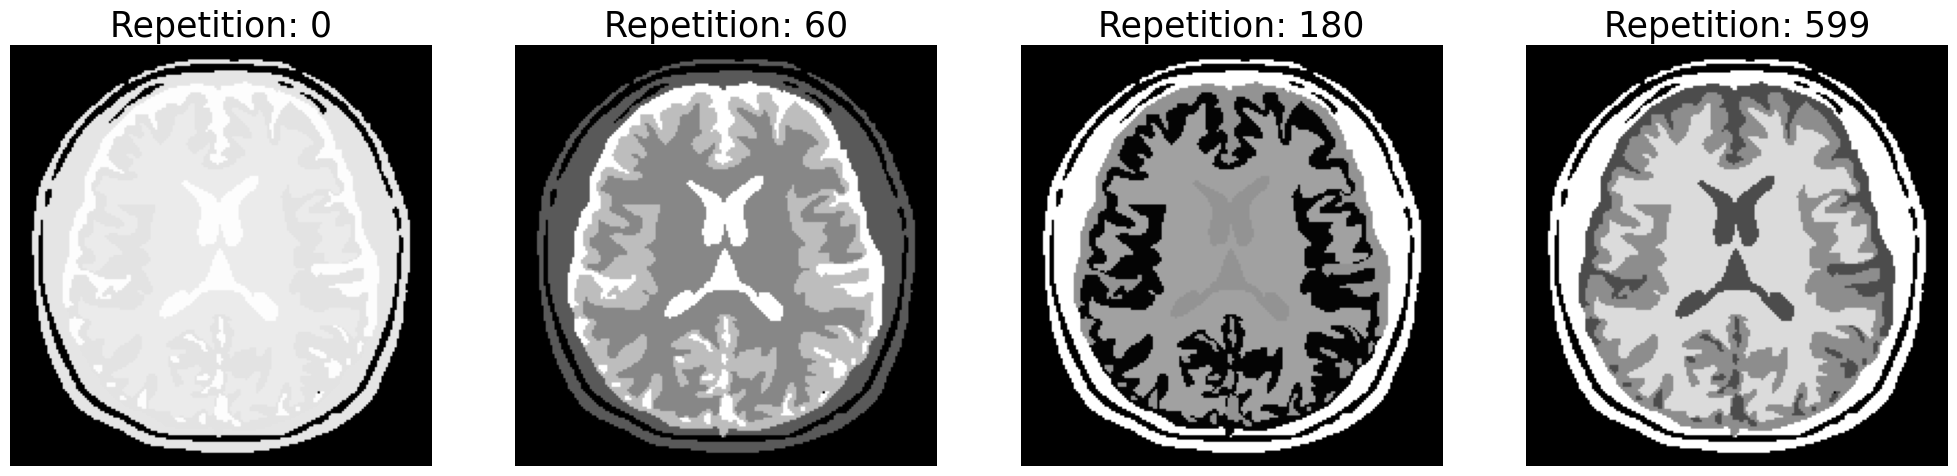

In [70]:
imshow_time('phantom_img2', [0, 60, 180, 599])

When comparing the spatial simulation with the reconstruction of the radially sampled frequency simulations a **black boundary/ink artifact** appears.
It is located around the CSF in the reconstruction of the frequency simulation at the 180-th repetition and is a well known effect of FLASH sequences.

This realistic effect can not be found in the simulation in spatial domain because neighboring pixels can not interact.

## Nonlinear Inversion of the Bloch Equations

This section of the tutorial introduces the model-based reconstruction technique developed for the work

> Quantitative Magnetic Resonance Imaging by Nonlinear Inversion of the Bloch Equations.  
> Nick Scholand, Xiaoqing Wang, Volkert Roeloffs, Sebastian Rosenzweig, Martin Uecker.  
> Magn Reson Med. 90:520-538 (2023). doi: 10.1002/mrm.29664

Next, this tutorial introduces the nonlinear inversion of the Bloch equations, also referred to as Bloch model-based reconstruction. This tool has been added with the `--bloch` flag to the `moba` tool in BART.
Because this reconstruction is computationally demanding, it is highly recommended to run it on a GPU. By removing the `-g` flag from the individual commands all tool also run on CPU only.

### IR bSSFP Reconstruction

In the first example, the Bloch model-based reconstruction is used to determine quantitative parameter maps from an IR bSSFP sequence.

#### Create Dataset

The numerical dataset is created using BARTs `sim` and `phantom` tool.
For simplicity, a single coil BRAIN phantom is simulated in k-space measured with a single-shot IR bSSFP sequence and golden-ratio based sampling.


In [71]:
%%bash

# Sequence Parameter
TR=0.0045 #[s]
TE=0.00225 #[s]
TRF=0.001 #[s]
REP=600
FA=45 #[deg]
BWTP=4

## Relaxation parameters for Brain phantom
T1=(0.6 3 1.5 0.8)	# [s]
T2=(0.08 1 0.06 0.1)	# [s]


# Run simulation and save output to $DURATION variable defining the simulation time

## 0th component
bart sim --ODE --seq IR-BSSFP,TR=$TR,TE=$TE,Nrep=$REP,pinv,ppl=$TE,Trf=$TRF,FA=$FA,BWTP=$BWTP -1 ${T1[0]}:${T1[0]}:1 -2 ${T2[0]}:${T2[0]}:1 _simu00

## 1th component
bart sim --ODE --seq IR-BSSFP,TR=$TR,TE=$TE,Nrep=$REP,pinv,ppl=$TE,Trf=$TRF,FA=$FA,BWTP=$BWTP -1 ${T1[1]}:${T1[1]}:1 -2 ${T2[1]}:${T2[1]}:1 _simu01

## 2th component
bart sim --ODE --seq IR-BSSFP,TR=$TR,TE=$TE,Nrep=$REP,pinv,ppl=$TE,Trf=$TRF,FA=$FA,BWTP=$BWTP -1 ${T1[2]}:${T1[2]}:1 -2 ${T2[2]}:${T2[2]}:1 _simu02

## 3th component
bart sim --ODE --seq IR-BSSFP,TR=$TR,TE=$TE,Nrep=$REP,pinv,ppl=$TE,Trf=$TRF,FA=$FA,BWTP=$BWTP -1 ${T1[3]}:${T1[3]}:1 -2 ${T2[3]}:${T2[3]}:1 _simu03

# Join individual simulations
bart join 7 _simu00 _simu01 _simu02 _simu03 simu

# Join simulations in a single dimension (-> 6)
bart reshape $(bart bitmask 6 7) 4 1 simu simu2

# Create Golden-Angle based Trajectory with 2-fold oversampling
SAMPLES=30
SPOKES=1

bart traj -x $((2*SAMPLES)) -y $SPOKES -o 2 -G -t $REP _traj

## The moba tool requires the time dimension to be in (5)!
bart transpose 5 10 _traj traj


# Simulate Spatial Components

## Create phantom based on trajectory
bart phantom --BRAIN -b -k -t traj comp_geom_ksp

# Combine simulated signal and spatial basis to create numerical dataset
bart fmac -s $(bart bitmask 6) comp_geom_ksp simu2 phantom_ksp

0.045299
0.048781
0.047105
0.047258


**Inversion Time**  

The inversion time is historically used by the `moba` tool to pass the time information to the underlying analytical forward operators. The Bloch model-based tool, does not require this vector. The timing information is included in the description of the simulated sequence: in the repetition time, the echo time, the number of repetitions,...

Still for compatibility to the previous versions the inversion time file TI still needs to be bassed. This will become optional in future releases of BART. For now, we create a dummy inversion time file.

In [72]:
%%bash

# Create dummy inversion time file

REP=600
bart index 5 ${REP} TI

#### Reconstruction

To make the `moba` tool use the Bloch simulation operator add `--bloch`.

The information about the applied sequence is passed with the `--seq` interface in the same way it is passed to the `sim` tool.

In [73]:
%%bash

bart moba --seq h

Usage of sub-option: --seq [BSSFP],[IR-BSSFP],[FLASH],[IR-FLASH],[TR=f],[TE=f],[Nspins=d],[Nrep=d],[pinv],[ipl=f],[isp=f],[ppl=f],[av-spokes=d],[Trf=f],[FA=f],[BWTP=f],[off=f],[sl-grad=f],[slice-thickness=f],[nom-slice-thickness=f]

Sub-options: configure sequence parameters

BSSFP                        bSSFP
IR-BSSFP                     Inversion-Recovery bSSFP
FLASH                        FLASH
IR-FLASH                     Inversion-Recovery FLASH
TR=float                     Repetition time [s]
TE=float                     Echo time [s]
Nspins=int                   Number of averaged spins
Nrep=int                     Number of repetitions
pinv                         Use perfect inversions
ipl=float                    Inversion Pulse Length [s]
isp=float                    Inversion Spoiler Gradient Length [s]
ppl=float                    Preparation Pulse Length [s]
av-spokes=                   Number of averaged consecutive spokes
Trf=float                    Pulse Duration [s]


In this example, we pass the sequence type, the repetition and echo time and many more parameter:
`ir-bssfp,tr=${TR},te=${TE},...`

The simulation type can be controlled with the `moba --sim` interface:

In [74]:
%%bash

bart moba --sim h

Usage of sub-option: --sim [ODE],[STM]

Sub-options: configure simulation parameters

ODE    full ordinary differential equation solver based simulation
STM    state-transition matrix based simulation (default)
h      help


Currently, it supports an ordinary differential equation solver (ODE) and a state-transition matrix (STM) simulation of the Bloch equations.

The flag `--img_dims $DIM:$DIM:1` defines the $k_{\text{max}}$ of the actual k-space by taking the two-fold oversampling into account.

The `moba --other` interface allows for passing further parameters like the partial derivative scalings, which define the preconditioning of the reconstructed parameter maps: [$R_1$, $M_0$, $R_2$, $B_1$]. With `--other pdscale=1:1:30:0` the optimization of the $B_1$ mapping is turned off (set to 0), the algorithm optimizes for $\hat{R_2}=3\cdot R_2$ and the other parameter maps are untouched.
In praxis this preconditioning often need to be tuned for a smooth convergence of the optimization. The scaling depends on the sequence type and its individual parameters. Later we will show an additional example for an IR FLASH sequence.

Besides tuning the preconditioning, we need to set the initialization values for the reconstruction `pinit=3:1:1:0`. Both are part of moba's `--other` interface. Please run `bart moba --other h` for more details. Further, the reconstruction needs some information about data and PSF scaling: `--scale_data=5000. --scale_psf=1000. --normalize_scaling`.

The iteratively regularized Gauss-Newton method and FISTA are both controlled similar to previous model-based publications by Xiaoqing Wang:

* Wang, X., Roeloffs, V., Klosowski, J., Tan, Z., Voit, D., Uecker, M. and Frahm, J. (2018), Model-based T1 mapping with sparsity constraints using single-shot inversion-recovery radial FLASH. Magn. Reson. Med, 79: 730-740. https://doi.org/10.1002/mrm.26726

*  Wang, X, Rosenzweig, S, Scholand, N, Holme, HCM, Uecker, M. Model-based reconstruction for simultaneous multi-slice T1 mapping using single-shot inversion-recovery radial FLASH. Magn Reson Med. 2020; 85: 1258– 1271. https://doi.org/10.1002/mrm.28497

* Wang, X, Tan, Z, Scholand, N, Roeloffs, V, Uecker, M. Physics-based reconstruction methods for magnetic resonance imaging. Phil Trans R Soc. 2021; A379: 20200196. https://doi.org/10.1098/rsta.2020.0196   .

We will not go into detail here, but the passed parameters are: `-i$ITER -C$INNER_ITER -s$STEP_SIZE -B$MIN_R1 -o$OS -R$REDU_FAC -j$LAMBDA -N`.

After discussing the interface, the next cell will execute the reconstruction. Depending on your system and the GPU this step can take about a minute.

If you do not want to use a GPU, remove the `-g` flag.

In [77]:
%%bash

OS=1
REDU_FAC=3
INNER_ITER=250
STEP_SIZE=0.95
MIN_R1=0.001
ITER=8
LAMBDA=0.0005

DIM=30
TR=0.0045 #[s]
TE=0.00225 #[s]
TRF=0.001 #[s]
REP=600
FA=45 #[deg]
BWTP=4

bart moba --bloch --sim STM --img_dims $DIM:$DIM:1 \
        --seq IR-BSSFP,TR=${TR},TE=${TE},ppl=${TE},FA=${FA},Trf=${TRF},BWTP=${BWTP},pinv \
        -g \
        --other pinit=3:1:1:0,pscale=1:1:30:0 --scale_data=5000. --scale_psf=1000. --normalize_scaling \
        -i$ITER -C$INNER_ITER -s$STEP_SIZE -B$MIN_R1 -d 4 -o$OS -R$REDU_FAC -j$LAMBDA -N \
        -t traj phantom_ksp TI reco_irbssfp1 sens


ksp : [  1 120   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 120   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 120   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 120   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 120   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 1519.348022
Scaling_psf: 4.664405
FP Scale[0]=1.000000
FP Scale[1]=1.000000
FP Scale[2]=30.000000
FP Scale[3]=0.000000
[ 60  60   1   1   1   1   4   1   1   1   1   1   1   1   1   1 ]
[ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
[ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
[ 60  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
[ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
imgs_dims:
	[ 60  60   1  

The chosen debug level of `-d 4` leads to the output above. It is highly recommended to receive direct feedback about the progress of the reconstruction.

#### Post-Processing

The output of the Bloch model-based reconstruction has the dimensions

In [78]:
%%bash

cat reco_irbssfp1.hdr

# Dimensions
60 60 1 1 1 1 4 1 1 1 1 1 1 1 1 1 
# Command
moba --bloch --sim STM --img_dims 30:30:1 --seq IR-BSSFP,TR=0.0045,TE=0.00225,ppl=0.00225,FA=45,Trf=0.001,BWTP=4,pinv -g --other pinit=3:1:1:0,pscale=1:1:30:0 --scale_data=5000. --scale_psf=1000. --normalize_scaling -i8 -C250 -s0.95 -B0.001 -d 4 -o1 -R3 -j0.0005 -N -t traj phantom_ksp TI reco_irbssfp1 sens 
# Files
 >sens >reco_irbssfp1 <TI <phantom_ksp <traj
# Creator
BART v0.9.00-633-geee06d5


60 x 60 samples for each of the 4 parameter maps.

Currently, the two-fold oversampling is not automatically compensated. Thus, we resize the data with `bart resize -c 0 $DIM 1 $DIM ...`.

The 6th dimension includes the parameter maps $R_1$, $M_0$, $R_2$ and $B_1$. We slice them `bart slice 6 ...` and invert the relaxation maps `bart spow -- -1 ...` to get the actual parameter maps $T_1$, $T_2$ and $B_1$. Multiplying the maps with a mask `bart fmac ...` can improve the visualization.

In [79]:
%%bash

# Post-Process Reconstruction

DIM=30

# Create Reference Maps

bart phantom --BRAIN -b -x $DIM b

bart vec 0.6 3 1.5 0.8 _vec_t1	# [s]
bart transpose 0 6 _vec_t1 vec_t1

bart vec 0.08 1 0.06 0.1 _vec_t2 # [s]
bart transpose 0 6 _vec_t2 vec_t2

bart ones 7 1 1 1 1 1 1 4 vec_fa

bart fmac -s $(bart bitmask 6) b vec_t1 t1ref
bart fmac -s $(bart bitmask 6) b vec_t2 t2ref
bart fmac -s $(bart bitmask 6) b vec_fa faref

bart fmac -s $(bart bitmask 6) b vec_fa mask

# Resize output of Reconstruction
# -> compensate for 2-fold oversampling
bart resize -c 0 $DIM 1 $DIM reco_irbssfp1 reco_crop


# Convert and Mask Reconstructed Maps

bart slice 6 0 reco_crop r1map
bart spow -- -1 r1map _t1map
bart fmac _t1map mask t1map_irbssfp1
rm _t1map.cfl _t1map.hdr

bart slice 6 2 reco_crop r2map
bart spow -- -1 r2map _t2map
bart fmac _t2map mask t2map_irbssfp1
rm _t2map.cfl _t2map.hdr

bart slice 6 3 reco_crop _famap
bart fmac _famap mask famap_irbssfp1
rm _famap.cfl _famap.hdr

Finally, the maps can be visualized.

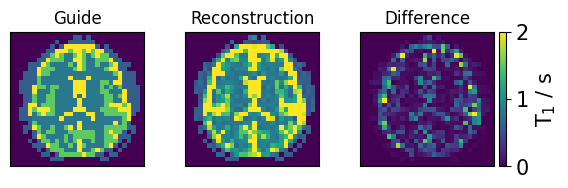

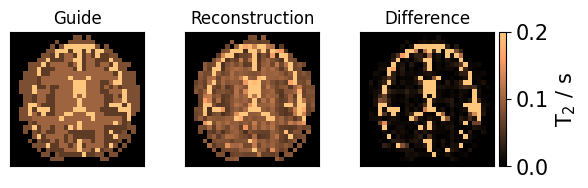

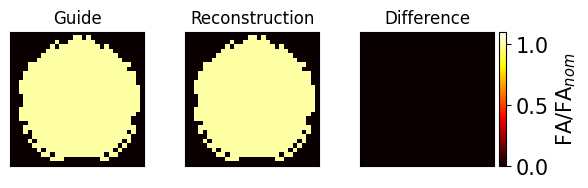

In [80]:
diffplot('t1map_irbssfp1', 't1ref', 2, 'viridis', 'T$_1$ / s')
diffplot('t2map_irbssfp1', 't2ref', 0.2, 'copper', 'T$_2$ / s')
diffplot('famap_irbssfp1', 'faref', 1.1, 'hot', 'FA/FA$_{nom}$')

The difference in the relative flip angle map is zero, because the flipangle optimization was turned off by setting the preconditioning scaling to 0: `pscale=1:1:3:0`.

We can observe some small checkboard artifacts and differences close to the edges of the maps, but the overall error for the reconstructed $T_1$ and $T_2$ maps is small.

### IR FLASH Reconstruction

Here, we present the reconstruction of IR FLASH data with the Bloch model-based reconstruction tool.

#### Create Dataset

The simulated data is created in the same way as presented in the example with an IR bSSFP sequence. Only some sequence parameters like TR, TE and the flipangle have been modified.

In [81]:
%%bash

# Sequence Parameter
TR=0.003 #[s]
TE=0.0017 #[s]
TRF=0.001 #[s]
REP=600
FA=8 #[deg]
BWTP=4


## Relaxation parameters for Brain phantom
T1=(0.6 3 1.5 0.8)	# [s]
T2=(0.08 1 0.06 0.1)	# [s]

# Run simulation and save output to $DURATION variable defining the simulation time

## 0th component
bart sim --ODE --seq IR-FLASH,TR=$TR,TE=$TE,Nrep=$REP,pinv,ppl=$TE,Trf=$TRF,FA=$FA,BWTP=$BWTP -1 ${T1[0]}:${T1[0]}:1 -2 ${T2[0]}:${T2[0]}:1 _simu00

## 1th component
bart sim --ODE --seq IR-FLASH,TR=$TR,TE=$TE,Nrep=$REP,pinv,ppl=$TE,Trf=$TRF,FA=$FA,BWTP=$BWTP -1 ${T1[1]}:${T1[1]}:1 -2 ${T2[1]}:${T2[1]}:1 _simu01

## 2th component
bart sim --ODE --seq IR-FLASH,TR=$TR,TE=$TE,Nrep=$REP,pinv,ppl=$TE,Trf=$TRF,FA=$FA,BWTP=$BWTP -1 ${T1[2]}:${T1[2]}:1 -2 ${T2[2]}:${T2[2]}:1 _simu02

## 3th component
bart sim --ODE --seq IR-FLASH,TR=$TR,TE=$TE,Nrep=$REP,pinv,ppl=$TE,Trf=$TRF,FA=$FA,BWTP=$BWTP -1 ${T1[3]}:${T1[3]}:1 -2 ${T2[3]}:${T2[3]}:1 _simu03

# Join individual simulations
bart join 7 _simu00 _simu01 _simu02 _simu03 simu

# Join simulations in a single dimension (-> 6)
bart reshape $(bart bitmask 6 7) 4 1 simu simu2

# We reuse the geometry "comp_geom_ksp" we calculated before

# Combine simulated signal and spatial basis to create numerical dataset
bart fmac -s $(bart bitmask 6) comp_geom_ksp simu2 phantom_ksp

0.063989
0.067584
0.078863
0.076372


#### Reconstruction

The reconstruction works similar as in the IR bSSFP case. Only the modified sequence parameters and the partial scaling need to be adjusted.

In the IR bSSFP reconstruction we used a scaling of `pscale=1:1:3:0`, which turned off the flipangle optimization and preconditioned to optimize for $\hat{R_2}=3\cdot R_2$ instead of $R_2$. An IR FLASH sequence is sensitive to $T_1$, $M_0$ and the flipangle. Therefore, the scaling is set to `pscale=1:1:0:1`. It constraints $R_2$ to be fixed and optimized for the flipangle. To observe an effect of the flipangle optimization the reconstruction assumes a nominal flipangle of 6 degree, which differs from the simulation. Thus, we expect a resulting relative flipangle map of $8/6=1.\bar{33}$.

In [82]:
%%bash

OS=1
REDU_FAC=3
INNER_ITER=250
STEP_SIZE=0.95
MIN_R1=0.001
ITER=8
LAMBDA=0.0005

DIM=30
TR=0.003 #[s]
TE=0.0017 #[s]
TRF=0.001 #[s]
REP=600
FA=6 #[deg] ! Note: By purpose not the same as in the simulation !
BWTP=4

bart moba --bloch --sim STM --img_dims $DIM:$DIM:1 \
        --seq IR-FLASH,TR=${TR},TE=${TE},ppl=${TE},FA=${FA},Trf=${TRF},BWTP=${BWTP},pinv \
        -g \
        --other pinit=3:1:1:0,pscale=1:1:0:1 --scale_data=5000. --scale_psf=1000. --normalize_scaling \
        -i$ITER -C$INNER_ITER -s$STEP_SIZE -B$MIN_R1 -d 4 -o$OS -R$REDU_FAC -j$LAMBDA -N \
        -t traj phantom_ksp TI reco_irflash sens


ksp : [  1 120   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 120   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 120   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 120   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 120   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 5043.248535
Scaling_psf: 4.664405
FP Scale[0]=1.000000
FP Scale[1]=1.000000
FP Scale[2]=0.000000
FP Scale[3]=1.000000
[ 60  60   1   1   1   1   4   1   1   1   1   1   1   1   1   1 ]
[ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
[ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
[ 60  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
[ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
imgs_dims:
	[ 60  60   1   

#### Post-Processing

The post-processing is the same as in the IR bSSFP example. Only the reference values have been adjusted.

In [83]:
%%bash

# Post-Process Reconstruction

DIM=30
FA_EFF=1.3333 # [s], Simulated FA (8 deg) / Reconstructed FA (6 deg)


# Create Reference Maps

bart phantom --BRAIN -b -x $DIM b

bart vec 0.6 3 1.5 0.8 _vec_t1	# [s]
bart transpose 0 6 _vec_t1 vec_t1

bart vec 0.08 1 0.06 0.1 _vec_t2 # [s]
bart transpose 0 6 _vec_t2 vec_t2

bart ones 7 1 1 1 1 1 1 4 _vec_fa
bart scale $FA_EFF _vec_fa vec_fa


bart fmac -s $(bart bitmask 6) b vec_t1 t1ref
bart fmac -s $(bart bitmask 6) b vec_t2 t2ref
bart fmac -s $(bart bitmask 6) b vec_fa faref

bart fmac -s $(bart bitmask 6) b _vec_fa mask


# Resize output of Reconstruction
# -> compensate for 2-fold oversampling
bart resize -c 0 $DIM 1 $DIM reco_irflash reco_crop


# Convert and Mask Reconstructed Maps

bart slice 6 0 reco_crop r1map
bart spow -- -1 r1map _t1map
bart fmac _t1map mask t1map_irflash
rm _t1map.cfl _t1map.hdr

bart slice 6 2 reco_crop r2map
bart spow -- -1 r2map _t2map
bart fmac _t2map mask t2map_irflash
rm _t2map.cfl _t2map.hdr

bart slice 6 3 reco_crop _famap
bart fmac _famap mask famap_irflash
rm _famap.cfl _famap.hdr

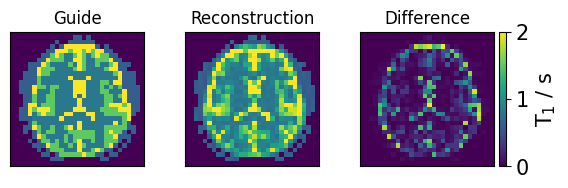

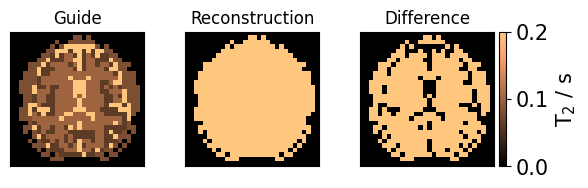

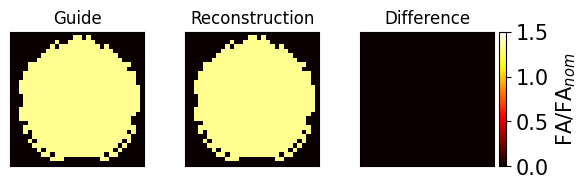

In [84]:
diffplot('t1map_irflash', 't1ref', 2, 'viridis', 'T$_1$ / s')
diffplot('t2map_irflash', 't2ref', 0.2, 'copper', 'T$_2$ / s')
diffplot('famap_irflash', 'faref', 1.5, 'hot', 'FA/FA$_{nom}$')

The $T_1$ map only shows small errors to the reference guide.

The constraining of the $T_2$ map by passing `pscale=1:1:0:1` to the `moba` call is visualized in the final $T_2$ map, because it still has the same value with which it has been initialized with.

The reconstruction assumed a nominal flip angle of 6 degree, while the simulation was based on a forward model assuming an 8 degree pulse. Thus, the reconstructed relative FA map is 1.33 and compensates the model differences. This map is estimated accurately.

In [ ]:
%%bash
rm *.{hdr,cfl}